<a href="https://colab.research.google.com/github/ricyoung/cs689/blob/master/gan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check GPU for colabs and add tf 1

In [24]:
%tensorflow_version 1.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [25]:
!nvidia-smi

Fri Apr  3 01:10:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    31W / 250W |    517MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Load libs

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from tensorflow.python.keras.layers import Dense, Dropout, Input
from tensorflow.python.keras.models import Model,Sequential
from tensorflow.python.keras.datasets import mnist
from tqdm import tqdm
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam

Mount Google Drive

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [20]:
#!mkdir /content/drive/'My Drive'/GAN_mnist
 !ls -lsa /content/drive/'My Drive'/GAN_mnist

total 0


Load Mnist


In [27]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)
(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

(60000, 784)


Def the Optimizer Parameter

In [0]:
def adam_optimizer():
    return Adam(lr=0.0006, beta_1=0.5)

Now we need to generate a generator 

In [29]:
def create_generator():
    generator=Sequential()
    ## Input is a 100 dimensional random noise
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer='adam')
    return generator
g=create_generator()
g.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 784)              

Now to the discriinator 

In [7]:

def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))           
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))    
    discriminator.add(Dense(units=1, activation='sigmoid'))    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
d =create_discriminator()
d.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
__________________________

Merger Gan and Dis

In [30]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


Now - Generate MNIST Images

In [0]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('/content/drive/''My Drive''/GAN_mnist/gan_generated_image %d.png' %epoch)

lets train the network

In [0]:
def training(epochs=10, batch_size=256):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)

LETS RUN THIS CODE


  0%|          | 0/256 [00:00<?, ?it/s]

Epoch 1


  2%|▏         | 5/256 [00:00<00:05, 46.04it/s]

Epoch 2


  2%|▏         | 5/256 [00:00<00:05, 45.81it/s]

Epoch 3


  2%|▏         | 5/256 [00:00<00:05, 46.88it/s]

Epoch 4


  2%|▏         | 5/256 [00:00<00:05, 49.77it/s]

Epoch 5


  2%|▏         | 6/256 [00:00<00:04, 52.72it/s]

Epoch 6


  2%|▏         | 6/256 [00:00<00:04, 51.15it/s]

Epoch 7


  2%|▏         | 6/256 [00:00<00:04, 51.80it/s]

Epoch 8


  2%|▏         | 6/256 [00:00<00:04, 51.75it/s]

Epoch 9


  2%|▏         | 6/256 [00:00<00:04, 52.48it/s]

Epoch 10


  2%|▏         | 5/256 [00:00<00:05, 45.98it/s]

Epoch 11


  2%|▏         | 5/256 [00:00<00:05, 48.29it/s]

Epoch 12


  2%|▏         | 5/256 [00:00<00:05, 49.95it/s]

Epoch 13


  2%|▏         | 5/256 [00:00<00:05, 49.98it/s]

Epoch 14


  2%|▏         | 6/256 [00:00<00:04, 50.49it/s]

Epoch 15


  2%|▏         | 6/256 [00:00<00:04, 51.41it/s]

Epoch 16


  2%|▏         | 6/256 [00:00<00:04, 52.40it/s]

Epoch 17


  2%|▏         | 5/256 [00:00<00:05, 42.71it/s]

Epoch 18


  2%|▏         | 6/256 [00:00<00:04, 51.94it/s]

Epoch 19


  2%|▏         | 5/256 [00:00<00:05, 47.34it/s]

Epoch 20


  2%|▏         | 5/256 [00:00<00:05, 47.83it/s]

Epoch 21


  2%|▏         | 5/256 [00:00<00:05, 47.16it/s]

Epoch 22


  2%|▏         | 5/256 [00:00<00:05, 45.96it/s]

Epoch 23


  2%|▏         | 6/256 [00:00<00:04, 50.87it/s]

Epoch 24


  2%|▏         | 6/256 [00:00<00:04, 50.27it/s]

Epoch 25


  2%|▏         | 6/256 [00:00<00:04, 52.00it/s]

Epoch 26


  2%|▏         | 6/256 [00:00<00:05, 49.73it/s]

Epoch 27


  2%|▏         | 6/256 [00:00<00:04, 50.64it/s]

Epoch 28


  2%|▏         | 6/256 [00:00<00:04, 50.14it/s]

Epoch 29


  2%|▏         | 6/256 [00:00<00:05, 48.61it/s]

Epoch 30


  2%|▏         | 5/256 [00:00<00:05, 48.94it/s]

Epoch 31


  2%|▏         | 5/256 [00:00<00:05, 47.91it/s]

Epoch 32


  2%|▏         | 5/256 [00:00<00:05, 48.10it/s]

Epoch 33


  2%|▏         | 6/256 [00:00<00:04, 50.79it/s]

Epoch 34


  2%|▏         | 5/256 [00:00<00:05, 47.11it/s]

Epoch 35


  2%|▏         | 5/256 [00:00<00:05, 48.35it/s]

Epoch 36


  2%|▏         | 5/256 [00:00<00:05, 48.72it/s]

Epoch 37


  2%|▏         | 5/256 [00:00<00:05, 45.22it/s]

Epoch 38


  2%|▏         | 6/256 [00:00<00:04, 50.99it/s]

Epoch 39


  2%|▏         | 5/256 [00:00<00:05, 49.69it/s]

Epoch 40


  2%|▏         | 5/256 [00:00<00:05, 44.18it/s]

Epoch 41


  2%|▏         | 5/256 [00:00<00:05, 44.82it/s]

Epoch 42


  2%|▏         | 6/256 [00:00<00:04, 51.55it/s]

Epoch 43


  2%|▏         | 6/256 [00:00<00:04, 50.79it/s]

Epoch 44


  2%|▏         | 5/256 [00:00<00:05, 49.00it/s]

Epoch 45


  2%|▏         | 5/256 [00:00<00:05, 48.88it/s]

Epoch 46


  2%|▏         | 5/256 [00:00<00:05, 48.86it/s]

Epoch 47


  2%|▏         | 5/256 [00:00<00:05, 46.05it/s]

Epoch 48


  2%|▏         | 6/256 [00:00<00:04, 50.72it/s]

Epoch 49


  2%|▏         | 5/256 [00:00<00:05, 47.14it/s]

Epoch 50


  2%|▏         | 6/256 [00:00<00:04, 52.83it/s]

Epoch 51


  2%|▏         | 5/256 [00:00<00:05, 47.39it/s]

Epoch 52


  2%|▏         | 6/256 [00:00<00:04, 50.65it/s]

Epoch 53


  2%|▏         | 6/256 [00:00<00:04, 52.63it/s]

Epoch 54


  2%|▏         | 6/256 [00:00<00:04, 51.60it/s]

Epoch 55


  2%|▏         | 5/256 [00:00<00:05, 45.55it/s]

Epoch 56


  2%|▏         | 5/256 [00:00<00:05, 45.34it/s]

Epoch 57


  2%|▏         | 5/256 [00:00<00:05, 48.89it/s]

Epoch 58


  2%|▏         | 5/256 [00:00<00:05, 47.95it/s]

Epoch 59


  2%|▏         | 5/256 [00:00<00:05, 46.04it/s]

Epoch 60


  2%|▏         | 5/256 [00:00<00:05, 48.53it/s]

Epoch 61


  2%|▏         | 5/256 [00:00<00:05, 46.09it/s]

Epoch 62


  2%|▏         | 5/256 [00:00<00:05, 48.10it/s]

Epoch 63


  2%|▏         | 6/256 [00:00<00:04, 50.73it/s]

Epoch 64


  2%|▏         | 5/256 [00:00<00:05, 49.56it/s]

Epoch 65


  2%|▏         | 6/256 [00:00<00:04, 51.22it/s]

Epoch 66


  2%|▏         | 5/256 [00:00<00:06, 41.54it/s]

Epoch 67


  2%|▏         | 5/256 [00:00<00:05, 46.51it/s]

Epoch 68


  2%|▏         | 6/256 [00:00<00:04, 50.28it/s]

Epoch 69


  2%|▏         | 5/256 [00:00<00:05, 49.37it/s]

Epoch 70


  2%|▏         | 6/256 [00:00<00:04, 50.74it/s]

Epoch 71


  2%|▏         | 5/256 [00:00<00:05, 46.85it/s]

Epoch 72


  2%|▏         | 5/256 [00:00<00:05, 46.23it/s]

Epoch 73


  2%|▏         | 5/256 [00:00<00:05, 49.08it/s]

Epoch 74


  2%|▏         | 5/256 [00:00<00:05, 48.41it/s]

Epoch 75


  2%|▏         | 6/256 [00:00<00:04, 50.99it/s]

Epoch 76


  2%|▏         | 5/256 [00:00<00:05, 47.15it/s]

Epoch 77


  2%|▏         | 5/256 [00:00<00:05, 48.03it/s]

Epoch 78


  2%|▏         | 5/256 [00:00<00:05, 46.64it/s]

Epoch 79


  2%|▏         | 5/256 [00:00<00:05, 43.00it/s]

Epoch 80


  2%|▏         | 5/256 [00:00<00:05, 47.26it/s]

Epoch 81


  2%|▏         | 5/256 [00:00<00:05, 49.15it/s]

Epoch 82


  2%|▏         | 6/256 [00:00<00:04, 50.43it/s]

Epoch 83


  2%|▏         | 5/256 [00:00<00:05, 45.67it/s]

Epoch 84


  2%|▏         | 5/256 [00:00<00:05, 45.69it/s]

Epoch 85


  2%|▏         | 6/256 [00:00<00:04, 51.03it/s]

Epoch 86


  2%|▏         | 5/256 [00:00<00:05, 48.38it/s]

Epoch 87


  2%|▏         | 5/256 [00:00<00:05, 44.07it/s]

Epoch 88


  2%|▏         | 5/256 [00:00<00:05, 49.45it/s]

Epoch 89


  2%|▏         | 5/256 [00:00<00:05, 48.37it/s]

Epoch 90


  2%|▏         | 5/256 [00:00<00:05, 46.01it/s]

Epoch 91


  2%|▏         | 5/256 [00:00<00:05, 49.78it/s]

Epoch 92


  2%|▏         | 5/256 [00:00<00:05, 48.56it/s]

Epoch 93


  2%|▏         | 5/256 [00:00<00:05, 49.95it/s]

Epoch 94


  2%|▏         | 5/256 [00:00<00:05, 44.20it/s]

Epoch 95


  2%|▏         | 5/256 [00:00<00:05, 47.91it/s]

Epoch 96


  2%|▏         | 5/256 [00:00<00:05, 46.44it/s]

Epoch 97


  2%|▏         | 5/256 [00:00<00:05, 47.93it/s]

Epoch 98


  2%|▏         | 6/256 [00:00<00:04, 50.05it/s]

Epoch 99


  2%|▏         | 5/256 [00:00<00:05, 49.57it/s]

Epoch 100


  2%|▏         | 5/256 [00:00<00:05, 48.79it/s]

Epoch 101


  2%|▏         | 6/256 [00:00<00:05, 49.99it/s]

Epoch 102


  2%|▏         | 5/256 [00:00<00:05, 48.11it/s]

Epoch 103


  2%|▏         | 6/256 [00:00<00:04, 50.83it/s]

Epoch 104


  2%|▏         | 5/256 [00:00<00:05, 48.50it/s]

Epoch 105


  2%|▏         | 5/256 [00:00<00:05, 47.96it/s]

Epoch 106


  2%|▏         | 5/256 [00:00<00:05, 49.93it/s]

Epoch 107


  2%|▏         | 5/256 [00:00<00:05, 44.71it/s]

Epoch 108


  2%|▏         | 5/256 [00:00<00:05, 47.75it/s]

Epoch 109


  2%|▏         | 6/256 [00:00<00:04, 50.27it/s]

Epoch 110


  2%|▏         | 5/256 [00:00<00:05, 48.71it/s]

Epoch 111


  2%|▏         | 5/256 [00:00<00:05, 48.62it/s]

Epoch 112


  2%|▏         | 5/256 [00:00<00:05, 48.96it/s]

Epoch 113


  2%|▏         | 5/256 [00:00<00:05, 48.90it/s]

Epoch 114


  2%|▏         | 5/256 [00:00<00:05, 49.44it/s]

Epoch 115


  2%|▏         | 5/256 [00:00<00:05, 43.83it/s]

Epoch 116


  2%|▏         | 5/256 [00:00<00:05, 48.78it/s]

Epoch 117


  2%|▏         | 5/256 [00:00<00:05, 48.68it/s]

Epoch 118


  2%|▏         | 5/256 [00:00<00:05, 47.46it/s]

Epoch 119


  2%|▏         | 6/256 [00:00<00:04, 50.64it/s]

Epoch 120


  2%|▏         | 5/256 [00:00<00:05, 46.18it/s]

Epoch 121


  2%|▏         | 5/256 [00:00<00:05, 47.53it/s]

Epoch 122


  2%|▏         | 6/256 [00:00<00:04, 50.61it/s]

Epoch 123


  2%|▏         | 5/256 [00:00<00:05, 47.52it/s]

Epoch 124


  2%|▏         | 5/256 [00:00<00:05, 49.74it/s]

Epoch 125


  2%|▏         | 5/256 [00:00<00:05, 46.72it/s]

Epoch 126


  2%|▏         | 5/256 [00:00<00:05, 49.76it/s]

Epoch 127


  2%|▏         | 6/256 [00:00<00:04, 50.84it/s]

Epoch 128


  2%|▏         | 5/256 [00:00<00:05, 47.32it/s]

Epoch 129


  2%|▏         | 6/256 [00:00<00:04, 50.09it/s]

Epoch 130


  2%|▏         | 5/256 [00:00<00:05, 47.47it/s]

Epoch 131


  2%|▏         | 5/256 [00:00<00:05, 48.46it/s]

Epoch 132


  2%|▏         | 5/256 [00:00<00:05, 46.88it/s]

Epoch 133


  2%|▏         | 5/256 [00:00<00:05, 46.87it/s]

Epoch 134


  2%|▏         | 5/256 [00:00<00:05, 48.71it/s]

Epoch 135


  2%|▏         | 5/256 [00:00<00:05, 42.08it/s]

Epoch 136


  2%|▏         | 5/256 [00:00<00:05, 47.47it/s]

Epoch 137


  2%|▏         | 5/256 [00:00<00:05, 49.70it/s]

Epoch 138


  2%|▏         | 5/256 [00:00<00:05, 45.49it/s]

Epoch 139


  2%|▏         | 5/256 [00:00<00:05, 47.66it/s]

Epoch 140


  2%|▏         | 5/256 [00:00<00:05, 43.27it/s]

Epoch 141


  2%|▏         | 5/256 [00:00<00:05, 45.41it/s]

Epoch 142


  2%|▏         | 6/256 [00:00<00:04, 52.15it/s]

Epoch 143


  2%|▏         | 5/256 [00:00<00:05, 49.64it/s]

Epoch 144


  2%|▏         | 5/256 [00:00<00:05, 46.50it/s]

Epoch 145


  2%|▏         | 6/256 [00:00<00:04, 50.46it/s]

Epoch 146


  2%|▏         | 6/256 [00:00<00:04, 50.39it/s]

Epoch 147


  2%|▏         | 6/256 [00:00<00:04, 50.58it/s]

Epoch 148


  2%|▏         | 6/256 [00:00<00:04, 50.87it/s]

Epoch 149


  2%|▏         | 5/256 [00:00<00:05, 47.74it/s]

Epoch 150


  2%|▏         | 6/256 [00:00<00:04, 51.43it/s]

Epoch 151


  2%|▏         | 5/256 [00:00<00:05, 49.14it/s]

Epoch 152


  2%|▏         | 5/256 [00:00<00:05, 49.31it/s]

Epoch 153


  2%|▏         | 6/256 [00:00<00:05, 47.01it/s]

Epoch 154


  2%|▏         | 5/256 [00:00<00:05, 49.22it/s]

Epoch 155


  2%|▏         | 5/256 [00:00<00:05, 48.24it/s]

Epoch 156


  2%|▏         | 5/256 [00:00<00:05, 49.94it/s]

Epoch 157


  2%|▏         | 5/256 [00:00<00:05, 45.95it/s]

Epoch 158


  2%|▏         | 5/256 [00:00<00:05, 49.09it/s]

Epoch 159


  2%|▏         | 5/256 [00:00<00:05, 48.89it/s]

Epoch 160


  2%|▏         | 5/256 [00:00<00:05, 48.69it/s]

Epoch 161


  2%|▏         | 5/256 [00:00<00:05, 47.10it/s]

Epoch 162


  2%|▏         | 4/256 [00:00<00:06, 38.64it/s]

Epoch 163


  2%|▏         | 5/256 [00:00<00:05, 49.44it/s]

Epoch 164


  2%|▏         | 5/256 [00:00<00:05, 43.97it/s]

Epoch 165


  2%|▏         | 6/256 [00:00<00:04, 50.56it/s]

Epoch 166


  2%|▏         | 5/256 [00:00<00:05, 47.11it/s]

Epoch 167


  2%|▏         | 6/256 [00:00<00:04, 51.12it/s]

Epoch 168


  2%|▏         | 5/256 [00:00<00:05, 49.79it/s]

Epoch 169


  2%|▏         | 5/256 [00:00<00:05, 47.88it/s]

Epoch 170


  2%|▏         | 5/256 [00:00<00:05, 48.92it/s]

Epoch 171


  2%|▏         | 5/256 [00:00<00:05, 44.95it/s]

Epoch 172


  2%|▏         | 5/256 [00:00<00:05, 48.97it/s]

Epoch 173


  2%|▏         | 6/256 [00:00<00:04, 52.05it/s]

Epoch 174


  2%|▏         | 5/256 [00:00<00:05, 46.13it/s]

Epoch 175


  2%|▏         | 5/256 [00:00<00:05, 49.75it/s]

Epoch 176


  2%|▏         | 6/256 [00:00<00:04, 50.44it/s]

Epoch 177


  2%|▏         | 5/256 [00:00<00:05, 49.14it/s]

Epoch 178


  2%|▏         | 6/256 [00:00<00:04, 50.82it/s]

Epoch 179


  2%|▏         | 5/256 [00:00<00:05, 44.31it/s]

Epoch 180


  2%|▏         | 5/256 [00:00<00:05, 48.23it/s]

Epoch 181


  2%|▏         | 5/256 [00:00<00:05, 45.65it/s]

Epoch 182


  2%|▏         | 5/256 [00:00<00:05, 47.26it/s]

Epoch 183


  2%|▏         | 5/256 [00:00<00:05, 48.49it/s]

Epoch 184


  2%|▏         | 5/256 [00:00<00:05, 48.28it/s]

Epoch 185


  2%|▏         | 5/256 [00:00<00:05, 48.28it/s]

Epoch 186


  2%|▏         | 5/256 [00:00<00:05, 49.89it/s]

Epoch 187


  2%|▏         | 5/256 [00:00<00:05, 47.55it/s]

Epoch 188


  2%|▏         | 5/256 [00:00<00:05, 49.10it/s]

Epoch 189


  2%|▏         | 5/256 [00:00<00:05, 48.64it/s]

Epoch 190


  2%|▏         | 5/256 [00:00<00:05, 49.71it/s]

Epoch 191


  2%|▏         | 6/256 [00:00<00:04, 50.85it/s]

Epoch 192


  2%|▏         | 5/256 [00:00<00:05, 45.70it/s]

Epoch 193


  2%|▏         | 5/256 [00:00<00:05, 45.10it/s]

Epoch 194


  2%|▏         | 5/256 [00:00<00:05, 47.39it/s]

Epoch 195


  2%|▏         | 5/256 [00:00<00:05, 48.31it/s]

Epoch 196


  2%|▏         | 5/256 [00:00<00:05, 44.30it/s]

Epoch 197


  2%|▏         | 5/256 [00:00<00:05, 47.54it/s]

Epoch 198


  2%|▏         | 5/256 [00:00<00:05, 48.53it/s]

Epoch 199


  2%|▏         | 5/256 [00:00<00:05, 48.13it/s]

Epoch 200


  2%|▏         | 5/256 [00:00<00:05, 44.23it/s]

Epoch 201


  2%|▏         | 5/256 [00:00<00:05, 43.62it/s]

Epoch 202


  2%|▏         | 5/256 [00:00<00:05, 47.41it/s]

Epoch 203


  2%|▏         | 5/256 [00:00<00:05, 48.01it/s]

Epoch 204


  2%|▏         | 5/256 [00:00<00:05, 48.17it/s]

Epoch 205


  2%|▏         | 5/256 [00:00<00:05, 47.89it/s]

Epoch 206


  2%|▏         | 5/256 [00:00<00:05, 47.78it/s]

Epoch 207


  2%|▏         | 6/256 [00:00<00:04, 50.20it/s]

Epoch 208


  2%|▏         | 5/256 [00:00<00:05, 48.57it/s]

Epoch 209


  2%|▏         | 5/256 [00:00<00:05, 49.81it/s]

Epoch 210


  2%|▏         | 6/256 [00:00<00:04, 50.40it/s]

Epoch 211


  2%|▏         | 6/256 [00:00<00:04, 52.76it/s]

Epoch 212


  2%|▏         | 6/256 [00:00<00:04, 51.91it/s]

Epoch 213


  2%|▏         | 5/256 [00:00<00:05, 48.14it/s]

Epoch 214


  2%|▏         | 5/256 [00:00<00:05, 49.77it/s]

Epoch 215


  2%|▏         | 5/256 [00:00<00:05, 47.73it/s]

Epoch 216


  2%|▏         | 5/256 [00:00<00:05, 48.68it/s]

Epoch 217


  2%|▏         | 6/256 [00:00<00:05, 48.01it/s]

Epoch 218


  2%|▏         | 6/256 [00:00<00:04, 50.04it/s]

Epoch 219


  2%|▏         | 5/256 [00:00<00:05, 44.63it/s]

Epoch 220


  2%|▏         | 5/256 [00:00<00:05, 45.23it/s]

Epoch 221


  2%|▏         | 5/256 [00:00<00:05, 49.47it/s]

Epoch 222


  2%|▏         | 6/256 [00:00<00:04, 52.15it/s]

Epoch 223


  2%|▏         | 6/256 [00:00<00:04, 52.25it/s]

Epoch 224


  2%|▏         | 5/256 [00:00<00:05, 49.07it/s]

Epoch 225


  2%|▏         | 6/256 [00:00<00:04, 53.67it/s]

Epoch 226


  2%|▏         | 6/256 [00:00<00:04, 53.25it/s]

Epoch 227


  2%|▏         | 6/256 [00:00<00:04, 51.01it/s]

Epoch 228


  2%|▏         | 6/256 [00:00<00:04, 50.80it/s]

Epoch 229


  2%|▏         | 6/256 [00:00<00:04, 51.39it/s]

Epoch 230


  2%|▏         | 6/256 [00:00<00:04, 51.84it/s]

Epoch 231


  2%|▏         | 6/256 [00:00<00:04, 55.33it/s]

Epoch 232


  2%|▏         | 6/256 [00:00<00:04, 52.68it/s]

Epoch 233


  2%|▏         | 5/256 [00:00<00:05, 49.23it/s]

Epoch 234


  2%|▏         | 5/256 [00:00<00:05, 49.96it/s]

Epoch 235


  2%|▏         | 5/256 [00:00<00:05, 48.16it/s]

Epoch 236


  2%|▏         | 6/256 [00:00<00:04, 50.27it/s]

Epoch 237


  2%|▏         | 6/256 [00:00<00:04, 50.88it/s]

Epoch 238


  2%|▏         | 6/256 [00:00<00:04, 50.98it/s]

Epoch 239


  2%|▏         | 6/256 [00:00<00:04, 52.06it/s]

Epoch 240


  2%|▏         | 5/256 [00:00<00:05, 47.84it/s]

Epoch 241


  2%|▏         | 6/256 [00:00<00:04, 53.02it/s]

Epoch 242


  2%|▏         | 6/256 [00:00<00:04, 52.20it/s]

Epoch 243


  2%|▏         | 6/256 [00:00<00:04, 52.27it/s]

Epoch 244


  2%|▏         | 6/256 [00:00<00:04, 50.45it/s]

Epoch 245


  2%|▏         | 5/256 [00:00<00:05, 48.81it/s]

Epoch 246


  2%|▏         | 6/256 [00:00<00:04, 52.03it/s]

Epoch 247


  2%|▏         | 6/256 [00:00<00:04, 52.73it/s]

Epoch 248


  2%|▏         | 6/256 [00:00<00:04, 50.77it/s]

Epoch 249


  2%|▏         | 6/256 [00:00<00:04, 54.56it/s]

Epoch 250


  2%|▏         | 6/256 [00:00<00:04, 51.65it/s]

Epoch 251


  2%|▏         | 6/256 [00:00<00:04, 51.27it/s]

Epoch 252


  2%|▏         | 5/256 [00:00<00:05, 45.20it/s]

Epoch 253


  2%|▏         | 6/256 [00:00<00:05, 49.42it/s]

Epoch 254


  2%|▏         | 6/256 [00:00<00:04, 52.57it/s]

Epoch 255


  2%|▏         | 6/256 [00:00<00:04, 52.59it/s]

Epoch 256


  2%|▏         | 6/256 [00:00<00:04, 52.94it/s]

Epoch 257


  2%|▏         | 6/256 [00:00<00:04, 53.56it/s]

Epoch 258


  2%|▏         | 6/256 [00:00<00:04, 51.95it/s]

Epoch 259


  2%|▏         | 6/256 [00:00<00:04, 50.99it/s]

Epoch 260


  1%|          | 3/256 [00:00<00:08, 29.92it/s]

Epoch 261


  2%|▏         | 6/256 [00:00<00:04, 50.79it/s]

Epoch 262


  2%|▏         | 5/256 [00:00<00:05, 42.63it/s]

Epoch 263


  2%|▏         | 6/256 [00:00<00:04, 52.21it/s]

Epoch 264


  2%|▏         | 6/256 [00:00<00:04, 50.87it/s]

Epoch 265


  2%|▏         | 6/256 [00:00<00:04, 50.78it/s]

Epoch 266


  2%|▏         | 5/256 [00:00<00:05, 49.32it/s]

Epoch 267


  2%|▏         | 6/256 [00:00<00:04, 51.69it/s]

Epoch 268


  2%|▏         | 6/256 [00:00<00:04, 51.85it/s]

Epoch 269


  2%|▏         | 6/256 [00:00<00:04, 52.55it/s]

Epoch 270


  2%|▏         | 6/256 [00:00<00:04, 54.64it/s]

Epoch 271


  2%|▏         | 6/256 [00:00<00:04, 51.60it/s]

Epoch 272


  2%|▏         | 6/256 [00:00<00:04, 53.70it/s]

Epoch 273


  2%|▏         | 6/256 [00:00<00:04, 52.09it/s]

Epoch 274


  2%|▏         | 6/256 [00:00<00:05, 49.87it/s]

Epoch 275


  2%|▏         | 5/256 [00:00<00:05, 49.91it/s]

Epoch 276


  2%|▏         | 6/256 [00:00<00:04, 51.96it/s]

Epoch 277


  2%|▏         | 6/256 [00:00<00:04, 50.43it/s]

Epoch 278


  2%|▏         | 6/256 [00:00<00:04, 50.95it/s]

Epoch 279


  2%|▏         | 6/256 [00:00<00:04, 51.59it/s]

Epoch 280


  2%|▏         | 5/256 [00:00<00:05, 45.08it/s]

Epoch 281


  2%|▏         | 6/256 [00:00<00:04, 50.00it/s]

Epoch 282


  2%|▏         | 5/256 [00:00<00:05, 46.52it/s]

Epoch 283


  2%|▏         | 6/256 [00:00<00:04, 51.35it/s]

Epoch 284


  2%|▏         | 5/256 [00:00<00:05, 49.07it/s]

Epoch 285


  2%|▏         | 5/256 [00:00<00:05, 48.76it/s]

Epoch 286


  2%|▏         | 5/256 [00:00<00:05, 48.44it/s]

Epoch 287


  2%|▏         | 5/256 [00:00<00:05, 48.02it/s]

Epoch 288


  2%|▏         | 6/256 [00:00<00:04, 51.46it/s]

Epoch 289


  2%|▏         | 6/256 [00:00<00:04, 52.47it/s]

Epoch 290


  2%|▏         | 5/256 [00:00<00:05, 49.70it/s]

Epoch 291


  2%|▏         | 6/256 [00:00<00:04, 50.81it/s]

Epoch 292


  2%|▏         | 6/256 [00:00<00:04, 51.90it/s]

Epoch 293


  2%|▏         | 6/256 [00:00<00:04, 52.07it/s]

Epoch 294


  2%|▏         | 6/256 [00:00<00:04, 51.21it/s]

Epoch 295


  2%|▏         | 6/256 [00:00<00:04, 51.81it/s]

Epoch 296


  2%|▏         | 5/256 [00:00<00:05, 49.29it/s]

Epoch 297


  2%|▏         | 6/256 [00:00<00:04, 51.11it/s]

Epoch 298


  2%|▏         | 6/256 [00:00<00:04, 50.76it/s]

Epoch 299


  2%|▏         | 5/256 [00:00<00:05, 49.29it/s]

Epoch 300


  2%|▏         | 5/256 [00:00<00:05, 48.42it/s]

Epoch 301


  2%|▏         | 6/256 [00:00<00:04, 51.15it/s]

Epoch 302


  2%|▏         | 6/256 [00:00<00:04, 53.24it/s]

Epoch 303


  2%|▏         | 5/256 [00:00<00:05, 47.08it/s]

Epoch 304


  2%|▏         | 5/256 [00:00<00:05, 49.36it/s]

Epoch 305


  2%|▏         | 5/256 [00:00<00:05, 49.88it/s]

Epoch 306


  2%|▏         | 6/256 [00:00<00:04, 50.99it/s]

Epoch 307


  2%|▏         | 6/256 [00:00<00:04, 50.68it/s]

Epoch 308


  2%|▏         | 6/256 [00:00<00:04, 51.23it/s]

Epoch 309


  2%|▏         | 5/256 [00:00<00:05, 44.13it/s]

Epoch 310


  2%|▏         | 6/256 [00:00<00:04, 50.85it/s]

Epoch 311


  2%|▏         | 5/256 [00:00<00:05, 47.32it/s]

Epoch 312


  2%|▏         | 6/256 [00:00<00:04, 51.53it/s]

Epoch 313


  2%|▏         | 6/256 [00:00<00:04, 50.80it/s]

Epoch 314


  2%|▏         | 5/256 [00:00<00:05, 49.45it/s]

Epoch 315


  2%|▏         | 6/256 [00:00<00:04, 53.23it/s]

Epoch 316


  2%|▏         | 6/256 [00:00<00:04, 50.78it/s]

Epoch 317


  2%|▏         | 6/256 [00:00<00:04, 52.46it/s]

Epoch 318


  2%|▏         | 6/256 [00:00<00:04, 52.14it/s]

Epoch 319


  2%|▏         | 6/256 [00:00<00:04, 52.34it/s]

Epoch 320


  2%|▏         | 5/256 [00:00<00:05, 48.78it/s]

Epoch 321


  2%|▏         | 6/256 [00:00<00:04, 50.94it/s]

Epoch 322


  2%|▏         | 6/256 [00:00<00:04, 52.04it/s]

Epoch 323


  2%|▏         | 6/256 [00:00<00:04, 52.24it/s]

Epoch 324


  2%|▏         | 5/256 [00:00<00:05, 47.37it/s]

Epoch 325


  2%|▏         | 6/256 [00:00<00:04, 50.94it/s]

Epoch 326


  2%|▏         | 6/256 [00:00<00:04, 50.40it/s]

Epoch 327


  2%|▏         | 6/256 [00:00<00:04, 53.20it/s]

Epoch 328


  2%|▏         | 6/256 [00:00<00:04, 51.93it/s]

Epoch 329


  2%|▏         | 6/256 [00:00<00:04, 51.73it/s]

Epoch 330


  2%|▏         | 5/256 [00:00<00:05, 47.58it/s]

Epoch 331


  2%|▏         | 5/256 [00:00<00:05, 49.93it/s]

Epoch 332


  2%|▏         | 6/256 [00:00<00:04, 53.64it/s]

Epoch 333


  2%|▏         | 6/256 [00:00<00:04, 53.32it/s]

Epoch 334


  2%|▏         | 6/256 [00:00<00:04, 53.98it/s]

Epoch 335


  2%|▏         | 6/256 [00:00<00:04, 52.24it/s]

Epoch 336


  2%|▏         | 5/256 [00:00<00:05, 49.17it/s]

Epoch 337


  2%|▏         | 6/256 [00:00<00:04, 50.69it/s]

Epoch 338


  2%|▏         | 5/256 [00:00<00:05, 48.36it/s]

Epoch 339


  2%|▏         | 6/256 [00:00<00:04, 51.66it/s]

Epoch 340


  2%|▏         | 5/256 [00:00<00:05, 47.58it/s]

Epoch 341


  2%|▏         | 5/256 [00:00<00:05, 47.66it/s]

Epoch 342


  2%|▏         | 5/256 [00:00<00:05, 49.67it/s]

Epoch 343


  2%|▏         | 6/256 [00:00<00:04, 52.36it/s]

Epoch 344


  2%|▏         | 6/256 [00:00<00:04, 50.91it/s]

Epoch 345


  2%|▏         | 6/256 [00:00<00:04, 52.90it/s]

Epoch 346


  2%|▏         | 6/256 [00:00<00:04, 50.58it/s]

Epoch 347


  2%|▏         | 6/256 [00:00<00:04, 52.99it/s]

Epoch 348


  2%|▏         | 6/256 [00:00<00:04, 53.83it/s]

Epoch 349


  2%|▏         | 6/256 [00:00<00:04, 52.66it/s]

Epoch 350


  2%|▏         | 5/256 [00:00<00:05, 48.87it/s]

Epoch 351


  2%|▏         | 6/256 [00:00<00:04, 51.05it/s]

Epoch 352


  2%|▏         | 6/256 [00:00<00:04, 51.24it/s]

Epoch 353


  2%|▏         | 6/256 [00:00<00:04, 51.80it/s]

Epoch 354


  2%|▏         | 6/256 [00:00<00:04, 51.17it/s]

Epoch 355


  2%|▏         | 5/256 [00:00<00:05, 45.63it/s]

Epoch 356


  2%|▏         | 5/256 [00:00<00:05, 47.12it/s]

Epoch 357


  2%|▏         | 6/256 [00:00<00:04, 53.41it/s]

Epoch 358


  2%|▏         | 6/256 [00:00<00:04, 53.28it/s]

Epoch 359


  2%|▏         | 6/256 [00:00<00:04, 53.33it/s]

Epoch 360


  2%|▏         | 6/256 [00:00<00:04, 50.95it/s]

Epoch 361


  2%|▏         | 6/256 [00:00<00:04, 51.25it/s]

Epoch 362


  2%|▏         | 5/256 [00:00<00:05, 47.75it/s]

Epoch 363


  2%|▏         | 5/256 [00:00<00:05, 47.82it/s]

Epoch 364


  2%|▏         | 6/256 [00:00<00:04, 52.48it/s]

Epoch 365


  2%|▏         | 6/256 [00:00<00:04, 51.20it/s]

Epoch 366


  2%|▏         | 5/256 [00:00<00:05, 49.28it/s]

Epoch 367


  2%|▏         | 5/256 [00:00<00:05, 47.62it/s]

Epoch 368


  2%|▏         | 6/256 [00:00<00:04, 50.85it/s]

Epoch 369


  2%|▏         | 5/256 [00:00<00:05, 46.20it/s]

Epoch 370


  2%|▏         | 5/256 [00:00<00:05, 48.31it/s]

Epoch 371


  2%|▏         | 5/256 [00:00<00:05, 43.46it/s]

Epoch 372


  2%|▏         | 5/256 [00:00<00:05, 42.84it/s]

Epoch 373


  2%|▏         | 4/256 [00:00<00:06, 39.03it/s]

Epoch 374


  2%|▏         | 5/256 [00:00<00:05, 49.78it/s]

Epoch 375


  2%|▏         | 6/256 [00:00<00:04, 50.49it/s]

Epoch 376


  2%|▏         | 5/256 [00:00<00:05, 48.98it/s]

Epoch 377


  2%|▏         | 5/256 [00:00<00:05, 49.80it/s]

Epoch 378


  2%|▏         | 5/256 [00:00<00:05, 47.92it/s]

Epoch 379


  2%|▏         | 5/256 [00:00<00:05, 49.74it/s]

Epoch 380


  2%|▏         | 5/256 [00:00<00:05, 45.21it/s]

Epoch 381


  2%|▏         | 5/256 [00:00<00:05, 49.64it/s]

Epoch 382


  2%|▏         | 6/256 [00:00<00:04, 50.95it/s]

Epoch 383


  2%|▏         | 5/256 [00:00<00:05, 47.07it/s]

Epoch 384


  2%|▏         | 6/256 [00:00<00:04, 51.74it/s]

Epoch 385


  2%|▏         | 6/256 [00:00<00:04, 51.69it/s]

Epoch 386


  2%|▏         | 6/256 [00:00<00:04, 53.38it/s]

Epoch 387


  2%|▏         | 5/256 [00:00<00:05, 48.91it/s]

Epoch 388


  2%|▏         | 6/256 [00:00<00:04, 50.94it/s]

Epoch 389


  2%|▏         | 5/256 [00:00<00:05, 49.06it/s]

Epoch 390


  2%|▏         | 5/256 [00:00<00:05, 47.62it/s]

Epoch 391


  2%|▏         | 6/256 [00:00<00:04, 52.41it/s]

Epoch 392


  2%|▏         | 6/256 [00:00<00:04, 51.75it/s]

Epoch 393


  2%|▏         | 6/256 [00:00<00:04, 51.07it/s]

Epoch 394


  2%|▏         | 5/256 [00:00<00:05, 48.37it/s]

Epoch 395


  2%|▏         | 6/256 [00:00<00:04, 50.66it/s]

Epoch 396


  2%|▏         | 5/256 [00:00<00:05, 48.40it/s]

Epoch 397


  2%|▏         | 6/256 [00:00<00:04, 53.00it/s]

Epoch 398


  2%|▏         | 6/256 [00:00<00:04, 52.75it/s]

Epoch 399


  2%|▏         | 5/256 [00:00<00:05, 49.32it/s]

Epoch 400


100%|██████████| 256/256 [00:05<00:00, 48.85it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
  2%|▏         | 5/256 [00:00<00:05, 49.64it/s]

Epoch 401


  2%|▏         | 5/256 [00:00<00:05, 48.75it/s]

Epoch 402


  2%|▏         | 6/256 [00:00<00:04, 52.83it/s]

Epoch 403


  2%|▏         | 6/256 [00:00<00:04, 52.23it/s]

Epoch 404


  2%|▏         | 5/256 [00:00<00:05, 49.77it/s]

Epoch 405


  2%|▏         | 6/256 [00:00<00:04, 51.10it/s]

Epoch 406


  2%|▏         | 5/256 [00:00<00:05, 47.42it/s]

Epoch 407


  2%|▏         | 5/256 [00:00<00:05, 48.12it/s]

Epoch 408


  2%|▏         | 5/256 [00:00<00:05, 49.30it/s]

Epoch 409


  2%|▏         | 6/256 [00:00<00:04, 51.41it/s]

Epoch 410


  2%|▏         | 6/256 [00:00<00:04, 52.42it/s]

Epoch 411


  2%|▏         | 6/256 [00:00<00:04, 50.61it/s]

Epoch 412


  2%|▏         | 6/256 [00:00<00:04, 50.56it/s]

Epoch 413


  2%|▏         | 5/256 [00:00<00:05, 47.11it/s]

Epoch 414


  2%|▏         | 5/256 [00:00<00:05, 49.05it/s]

Epoch 415


  2%|▏         | 5/256 [00:00<00:05, 49.94it/s]

Epoch 416


  2%|▏         | 6/256 [00:00<00:05, 49.86it/s]

Epoch 417


  2%|▏         | 6/256 [00:00<00:04, 51.71it/s]

Epoch 418


  2%|▏         | 6/256 [00:00<00:05, 49.57it/s]

Epoch 419


  2%|▏         | 6/256 [00:00<00:04, 52.00it/s]

Epoch 420


  2%|▏         | 5/256 [00:00<00:05, 46.10it/s]

Epoch 421


  2%|▏         | 5/256 [00:00<00:05, 48.09it/s]

Epoch 422


  2%|▏         | 6/256 [00:00<00:04, 52.44it/s]

Epoch 423


  2%|▏         | 6/256 [00:00<00:05, 48.04it/s]

Epoch 424


  2%|▏         | 5/256 [00:00<00:05, 47.86it/s]

Epoch 425


  2%|▏         | 5/256 [00:00<00:05, 48.12it/s]

Epoch 426


  2%|▏         | 6/256 [00:00<00:04, 52.88it/s]

Epoch 427


  2%|▏         | 6/256 [00:00<00:04, 51.95it/s]

Epoch 428


  2%|▏         | 6/256 [00:00<00:04, 51.44it/s]

Epoch 429


  2%|▏         | 6/256 [00:00<00:04, 51.23it/s]

Epoch 430


  2%|▏         | 6/256 [00:00<00:04, 51.54it/s]

Epoch 431


  2%|▏         | 6/256 [00:00<00:04, 51.59it/s]

Epoch 432


  2%|▏         | 5/256 [00:00<00:05, 47.37it/s]

Epoch 433


  2%|▏         | 5/256 [00:00<00:05, 46.63it/s]

Epoch 434


  2%|▏         | 6/256 [00:00<00:04, 52.07it/s]

Epoch 435


  2%|▏         | 6/256 [00:00<00:04, 50.93it/s]

Epoch 436


  2%|▏         | 5/256 [00:00<00:05, 48.57it/s]

Epoch 437


  2%|▏         | 5/256 [00:00<00:05, 49.94it/s]

Epoch 438


  2%|▏         | 6/256 [00:00<00:04, 51.91it/s]

Epoch 439


  2%|▏         | 6/256 [00:00<00:04, 52.69it/s]

Epoch 440


  2%|▏         | 5/256 [00:00<00:05, 46.34it/s]

Epoch 441


  2%|▏         | 5/256 [00:00<00:05, 49.91it/s]

Epoch 442


  2%|▏         | 5/256 [00:00<00:05, 47.41it/s]

Epoch 443


  2%|▏         | 5/256 [00:00<00:05, 47.41it/s]

Epoch 444


  2%|▏         | 5/256 [00:00<00:05, 44.75it/s]

Epoch 445


  2%|▏         | 5/256 [00:00<00:05, 48.90it/s]

Epoch 446


  2%|▏         | 6/256 [00:00<00:04, 51.50it/s]

Epoch 447


  2%|▏         | 6/256 [00:00<00:04, 50.02it/s]

Epoch 448


  2%|▏         | 6/256 [00:00<00:04, 53.03it/s]

Epoch 449


  2%|▏         | 6/256 [00:00<00:04, 51.64it/s]

Epoch 450


  2%|▏         | 5/256 [00:00<00:05, 47.33it/s]

Epoch 451


  2%|▏         | 6/256 [00:00<00:04, 51.30it/s]

Epoch 452


  2%|▏         | 6/256 [00:00<00:04, 51.38it/s]

Epoch 453


  2%|▏         | 6/256 [00:00<00:04, 52.13it/s]

Epoch 454


  2%|▏         | 6/256 [00:00<00:04, 51.36it/s]

Epoch 455


  2%|▏         | 5/256 [00:00<00:05, 49.81it/s]

Epoch 456


  2%|▏         | 6/256 [00:00<00:04, 51.66it/s]

Epoch 457


  2%|▏         | 6/256 [00:00<00:04, 50.34it/s]

Epoch 458


  2%|▏         | 5/256 [00:00<00:05, 48.41it/s]

Epoch 459


  2%|▏         | 5/256 [00:00<00:05, 49.46it/s]

Epoch 460


  2%|▏         | 5/256 [00:00<00:05, 47.62it/s]

Epoch 461


  2%|▏         | 5/256 [00:00<00:05, 47.64it/s]

Epoch 462


  2%|▏         | 5/256 [00:00<00:05, 42.86it/s]

Epoch 463


  2%|▏         | 6/256 [00:00<00:04, 53.49it/s]

Epoch 464


  2%|▏         | 5/256 [00:00<00:05, 46.87it/s]

Epoch 465


  2%|▏         | 5/256 [00:00<00:05, 48.58it/s]

Epoch 466


  2%|▏         | 6/256 [00:00<00:05, 49.34it/s]

Epoch 467


  2%|▏         | 5/256 [00:00<00:05, 45.95it/s]

Epoch 468


  2%|▏         | 5/256 [00:00<00:05, 47.77it/s]

Epoch 469


  2%|▏         | 6/256 [00:00<00:04, 51.56it/s]

Epoch 470


  2%|▏         | 6/256 [00:00<00:04, 50.63it/s]

Epoch 471


  2%|▏         | 6/256 [00:00<00:04, 51.43it/s]

Epoch 472


  2%|▏         | 6/256 [00:00<00:04, 53.67it/s]

Epoch 473


  2%|▏         | 5/256 [00:00<00:05, 48.13it/s]

Epoch 474


  2%|▏         | 6/256 [00:00<00:04, 50.47it/s]

Epoch 475


  2%|▏         | 5/256 [00:00<00:05, 49.31it/s]

Epoch 476


  2%|▏         | 5/256 [00:00<00:05, 48.86it/s]

Epoch 477


  2%|▏         | 6/256 [00:00<00:04, 51.23it/s]

Epoch 478


  2%|▏         | 6/256 [00:00<00:04, 51.77it/s]

Epoch 479


  2%|▏         | 6/256 [00:00<00:04, 51.31it/s]

Epoch 480


  2%|▏         | 5/256 [00:00<00:05, 48.90it/s]

Epoch 481


  2%|▏         | 5/256 [00:00<00:05, 47.57it/s]

Epoch 482


  2%|▏         | 5/256 [00:00<00:05, 49.69it/s]

Epoch 483


  2%|▏         | 5/256 [00:00<00:05, 49.63it/s]

Epoch 484


  2%|▏         | 5/256 [00:00<00:05, 46.58it/s]

Epoch 485


  2%|▏         | 5/256 [00:00<00:05, 48.78it/s]

Epoch 486


  2%|▏         | 6/256 [00:00<00:04, 51.07it/s]

Epoch 487


  2%|▏         | 5/256 [00:00<00:06, 40.45it/s]

Epoch 488


  2%|▏         | 6/256 [00:00<00:04, 50.81it/s]

Epoch 489


  2%|▏         | 6/256 [00:00<00:04, 50.57it/s]

Epoch 490


  2%|▏         | 5/256 [00:00<00:05, 46.39it/s]

Epoch 491


  2%|▏         | 6/256 [00:00<00:04, 52.47it/s]

Epoch 492


  2%|▏         | 5/256 [00:00<00:06, 39.84it/s]

Epoch 493


  2%|▏         | 5/256 [00:00<00:05, 49.29it/s]

Epoch 494


  2%|▏         | 6/256 [00:00<00:04, 51.95it/s]

Epoch 495


  2%|▏         | 6/256 [00:00<00:04, 50.67it/s]

Epoch 496


  2%|▏         | 5/256 [00:00<00:05, 45.34it/s]

Epoch 497


  2%|▏         | 5/256 [00:00<00:05, 48.63it/s]

Epoch 498


  2%|▏         | 4/256 [00:00<00:06, 39.55it/s]

Epoch 499


  2%|▏         | 5/256 [00:00<00:05, 49.20it/s]

Epoch 500


  2%|▏         | 5/256 [00:00<00:05, 43.02it/s]

Epoch 501


  2%|▏         | 6/256 [00:00<00:05, 47.70it/s]

Epoch 502


  2%|▏         | 6/256 [00:00<00:04, 50.62it/s]

Epoch 503


  2%|▏         | 6/256 [00:00<00:04, 51.55it/s]

Epoch 504


  2%|▏         | 6/256 [00:00<00:05, 49.75it/s]

Epoch 505


  2%|▏         | 6/256 [00:00<00:04, 50.85it/s]

Epoch 506


  2%|▏         | 5/256 [00:00<00:05, 49.42it/s]

Epoch 507


  2%|▏         | 6/256 [00:00<00:04, 50.98it/s]

Epoch 508


  2%|▏         | 6/256 [00:00<00:04, 51.58it/s]

Epoch 509


  2%|▏         | 5/256 [00:00<00:05, 47.99it/s]

Epoch 510


  2%|▏         | 5/256 [00:00<00:05, 46.41it/s]

Epoch 511


  2%|▏         | 5/256 [00:00<00:05, 47.40it/s]

Epoch 512


  2%|▏         | 5/256 [00:00<00:05, 46.72it/s]

Epoch 513


  2%|▏         | 6/256 [00:00<00:04, 52.18it/s]

Epoch 514


  2%|▏         | 6/256 [00:00<00:04, 52.15it/s]

Epoch 515


  2%|▏         | 5/256 [00:00<00:05, 48.67it/s]

Epoch 516


  2%|▏         | 5/256 [00:00<00:05, 47.00it/s]

Epoch 517


  2%|▏         | 6/256 [00:00<00:04, 51.88it/s]

Epoch 518


  2%|▏         | 6/256 [00:00<00:04, 53.66it/s]

Epoch 519


  2%|▏         | 6/256 [00:00<00:04, 51.68it/s]

Epoch 520


  2%|▏         | 5/256 [00:00<00:05, 49.18it/s]

Epoch 521


  2%|▏         | 5/256 [00:00<00:05, 49.77it/s]

Epoch 522


  2%|▏         | 6/256 [00:00<00:04, 51.05it/s]

Epoch 523


  2%|▏         | 5/256 [00:00<00:05, 49.12it/s]

Epoch 524


  2%|▏         | 6/256 [00:00<00:04, 51.83it/s]

Epoch 525


  2%|▏         | 5/256 [00:00<00:05, 48.76it/s]

Epoch 526


  2%|▏         | 5/256 [00:00<00:05, 47.96it/s]

Epoch 527


  2%|▏         | 5/256 [00:00<00:05, 48.74it/s]

Epoch 528


  2%|▏         | 6/256 [00:00<00:04, 50.94it/s]

Epoch 529


  2%|▏         | 6/256 [00:00<00:04, 51.33it/s]

Epoch 530


  2%|▏         | 6/256 [00:00<00:04, 50.70it/s]

Epoch 531


  2%|▏         | 6/256 [00:00<00:04, 52.08it/s]

Epoch 532


  2%|▏         | 5/256 [00:00<00:05, 47.94it/s]

Epoch 533


  2%|▏         | 5/256 [00:00<00:05, 48.69it/s]

Epoch 534


  2%|▏         | 6/256 [00:00<00:04, 51.75it/s]

Epoch 535


  2%|▏         | 5/256 [00:00<00:05, 48.99it/s]

Epoch 536


  2%|▏         | 5/256 [00:00<00:05, 48.16it/s]

Epoch 537


  2%|▏         | 6/256 [00:00<00:04, 51.39it/s]

Epoch 538


  2%|▏         | 5/256 [00:00<00:05, 48.95it/s]

Epoch 539


  2%|▏         | 5/256 [00:00<00:05, 47.20it/s]

Epoch 540


  2%|▏         | 5/256 [00:00<00:05, 48.20it/s]

Epoch 541


  2%|▏         | 6/256 [00:00<00:05, 49.57it/s]

Epoch 542


  2%|▏         | 5/256 [00:00<00:05, 49.35it/s]

Epoch 543


  2%|▏         | 5/256 [00:00<00:05, 48.33it/s]

Epoch 544


  2%|▏         | 5/256 [00:00<00:05, 49.20it/s]

Epoch 545


  2%|▏         | 6/256 [00:00<00:04, 52.08it/s]

Epoch 546


  2%|▏         | 5/256 [00:00<00:05, 49.70it/s]

Epoch 547


  2%|▏         | 5/256 [00:00<00:05, 44.52it/s]

Epoch 548


  2%|▏         | 5/256 [00:00<00:05, 48.39it/s]

Epoch 549


  2%|▏         | 5/256 [00:00<00:05, 44.60it/s]

Epoch 550


  2%|▏         | 5/256 [00:00<00:05, 45.19it/s]

Epoch 551


  2%|▏         | 6/256 [00:00<00:04, 50.95it/s]

Epoch 552


  2%|▏         | 5/256 [00:00<00:05, 45.99it/s]

Epoch 553


  2%|▏         | 5/256 [00:00<00:05, 49.63it/s]

Epoch 554


  2%|▏         | 5/256 [00:00<00:05, 48.24it/s]

Epoch 555


  2%|▏         | 6/256 [00:00<00:04, 51.17it/s]

Epoch 556


  2%|▏         | 6/256 [00:00<00:04, 50.58it/s]

Epoch 557


  2%|▏         | 6/256 [00:00<00:04, 52.96it/s]

Epoch 558


  2%|▏         | 6/256 [00:00<00:04, 51.29it/s]

Epoch 559


  2%|▏         | 6/256 [00:00<00:04, 51.90it/s]

Epoch 560


  2%|▏         | 5/256 [00:00<00:05, 44.08it/s]

Epoch 561


  2%|▏         | 5/256 [00:00<00:05, 49.08it/s]

Epoch 562


  2%|▏         | 6/256 [00:00<00:04, 51.24it/s]

Epoch 563


  2%|▏         | 6/256 [00:00<00:04, 52.54it/s]

Epoch 564


  2%|▏         | 5/256 [00:00<00:05, 46.14it/s]

Epoch 565


  2%|▏         | 5/256 [00:00<00:05, 46.52it/s]

Epoch 566


  2%|▏         | 5/256 [00:00<00:05, 49.47it/s]

Epoch 567


  2%|▏         | 6/256 [00:00<00:04, 51.34it/s]

Epoch 568


  2%|▏         | 6/256 [00:00<00:04, 51.77it/s]

Epoch 569


  2%|▏         | 6/256 [00:00<00:04, 51.80it/s]

Epoch 570


  2%|▏         | 5/256 [00:00<00:05, 49.90it/s]

Epoch 571


  2%|▏         | 6/256 [00:00<00:04, 51.26it/s]

Epoch 572


  2%|▏         | 4/256 [00:00<00:06, 39.25it/s]

Epoch 573


  2%|▏         | 5/256 [00:00<00:05, 45.66it/s]

Epoch 574


  2%|▏         | 5/256 [00:00<00:05, 47.88it/s]

Epoch 575


  2%|▏         | 5/256 [00:00<00:05, 48.97it/s]

Epoch 576


  2%|▏         | 5/256 [00:00<00:05, 45.01it/s]

Epoch 577


  2%|▏         | 5/256 [00:00<00:05, 48.18it/s]

Epoch 578


  2%|▏         | 5/256 [00:00<00:05, 49.92it/s]

Epoch 579


  2%|▏         | 5/256 [00:00<00:05, 49.62it/s]

Epoch 580


  2%|▏         | 5/256 [00:00<00:05, 43.94it/s]

Epoch 581


  2%|▏         | 5/256 [00:00<00:05, 49.88it/s]

Epoch 582


  2%|▏         | 6/256 [00:00<00:04, 52.26it/s]

Epoch 583


  2%|▏         | 5/256 [00:00<00:05, 43.68it/s]

Epoch 584


  2%|▏         | 6/256 [00:00<00:04, 51.79it/s]

Epoch 585


  2%|▏         | 6/256 [00:00<00:04, 50.71it/s]

Epoch 586


  2%|▏         | 6/256 [00:00<00:04, 51.14it/s]

Epoch 587


  2%|▏         | 5/256 [00:00<00:05, 42.98it/s]

Epoch 588


  2%|▏         | 5/256 [00:00<00:05, 44.51it/s]

Epoch 589


  2%|▏         | 5/256 [00:00<00:05, 47.07it/s]

Epoch 590


  2%|▏         | 6/256 [00:00<00:04, 51.72it/s]

Epoch 591


  2%|▏         | 6/256 [00:00<00:04, 52.34it/s]

Epoch 592


  2%|▏         | 6/256 [00:00<00:04, 51.34it/s]

Epoch 593


  2%|▏         | 5/256 [00:00<00:05, 48.18it/s]

Epoch 594


  2%|▏         | 6/256 [00:00<00:04, 52.95it/s]

Epoch 595


  2%|▏         | 6/256 [00:00<00:04, 51.41it/s]

Epoch 596


  2%|▏         | 6/256 [00:00<00:04, 51.46it/s]

Epoch 597


  2%|▏         | 5/256 [00:00<00:05, 44.53it/s]

Epoch 598


  2%|▏         | 5/256 [00:00<00:05, 49.60it/s]

Epoch 599


  2%|▏         | 5/256 [00:00<00:05, 49.06it/s]

Epoch 600


  2%|▏         | 5/256 [00:00<00:05, 42.56it/s]

Epoch 601


  2%|▏         | 6/256 [00:00<00:04, 50.29it/s]

Epoch 602


  2%|▏         | 6/256 [00:00<00:04, 51.41it/s]

Epoch 603


  2%|▏         | 6/256 [00:00<00:04, 51.40it/s]

Epoch 604


  2%|▏         | 5/256 [00:00<00:05, 47.38it/s]

Epoch 605


  2%|▏         | 5/256 [00:00<00:05, 45.46it/s]

Epoch 606


  2%|▏         | 5/256 [00:00<00:05, 49.44it/s]

Epoch 607


  2%|▏         | 6/256 [00:00<00:04, 52.23it/s]

Epoch 608


  2%|▏         | 6/256 [00:00<00:04, 50.62it/s]

Epoch 609


  2%|▏         | 6/256 [00:00<00:04, 52.59it/s]

Epoch 610


  2%|▏         | 6/256 [00:00<00:04, 50.55it/s]

Epoch 611


  2%|▏         | 5/256 [00:00<00:05, 45.96it/s]

Epoch 612


  2%|▏         | 6/256 [00:00<00:04, 51.00it/s]

Epoch 613


  2%|▏         | 6/256 [00:00<00:04, 51.03it/s]

Epoch 614


  2%|▏         | 6/256 [00:00<00:04, 50.60it/s]

Epoch 615


  2%|▏         | 5/256 [00:00<00:05, 48.12it/s]

Epoch 616


  2%|▏         | 5/256 [00:00<00:05, 49.62it/s]

Epoch 617


  2%|▏         | 5/256 [00:00<00:05, 44.77it/s]

Epoch 618


  2%|▏         | 5/256 [00:00<00:05, 47.32it/s]

Epoch 619


  2%|▏         | 6/256 [00:00<00:04, 51.91it/s]

Epoch 620


  2%|▏         | 5/256 [00:00<00:05, 44.87it/s]

Epoch 621


  2%|▏         | 5/256 [00:00<00:05, 48.26it/s]

Epoch 622


  2%|▏         | 5/256 [00:00<00:05, 48.97it/s]

Epoch 623


  2%|▏         | 6/256 [00:00<00:04, 50.11it/s]

Epoch 624


  2%|▏         | 5/256 [00:00<00:05, 49.21it/s]

Epoch 625


  2%|▏         | 6/256 [00:00<00:04, 52.97it/s]

Epoch 626


  2%|▏         | 5/256 [00:00<00:05, 48.51it/s]

Epoch 627


  2%|▏         | 5/256 [00:00<00:05, 49.11it/s]

Epoch 628


  2%|▏         | 5/256 [00:00<00:05, 49.08it/s]

Epoch 629


  2%|▏         | 5/256 [00:00<00:05, 47.90it/s]

Epoch 630


  2%|▏         | 5/256 [00:00<00:05, 48.63it/s]

Epoch 631


  2%|▏         | 5/256 [00:00<00:05, 48.99it/s]

Epoch 632


  2%|▏         | 5/256 [00:00<00:05, 48.35it/s]

Epoch 633


  2%|▏         | 5/256 [00:00<00:05, 49.79it/s]

Epoch 634


  2%|▏         | 6/256 [00:00<00:04, 50.38it/s]

Epoch 635


  2%|▏         | 5/256 [00:00<00:05, 47.28it/s]

Epoch 636


  2%|▏         | 6/256 [00:00<00:04, 52.17it/s]

Epoch 637


  2%|▏         | 6/256 [00:00<00:04, 50.04it/s]

Epoch 638


  2%|▏         | 5/256 [00:00<00:05, 49.80it/s]

Epoch 639


  2%|▏         | 5/256 [00:00<00:05, 49.27it/s]

Epoch 640


  2%|▏         | 5/256 [00:00<00:05, 47.07it/s]

Epoch 641


  2%|▏         | 5/256 [00:00<00:05, 48.60it/s]

Epoch 642


  2%|▏         | 5/256 [00:00<00:05, 47.45it/s]

Epoch 643


  2%|▏         | 6/256 [00:00<00:04, 50.43it/s]

Epoch 644


  2%|▏         | 5/256 [00:00<00:05, 43.81it/s]

Epoch 645


  2%|▏         | 6/256 [00:00<00:04, 51.27it/s]

Epoch 646


  2%|▏         | 5/256 [00:00<00:05, 48.51it/s]

Epoch 647


  2%|▏         | 5/256 [00:00<00:05, 45.48it/s]

Epoch 648


  2%|▏         | 6/256 [00:00<00:04, 51.71it/s]

Epoch 649


  2%|▏         | 5/256 [00:00<00:05, 49.52it/s]

Epoch 650


  2%|▏         | 5/256 [00:00<00:05, 47.46it/s]

Epoch 651


  2%|▏         | 5/256 [00:00<00:05, 48.92it/s]

Epoch 652


  2%|▏         | 5/256 [00:00<00:05, 45.08it/s]

Epoch 653


  2%|▏         | 5/256 [00:00<00:05, 48.14it/s]

Epoch 654


  2%|▏         | 6/256 [00:00<00:04, 51.16it/s]

Epoch 655


  2%|▏         | 5/256 [00:00<00:05, 48.77it/s]

Epoch 656


  2%|▏         | 5/256 [00:00<00:05, 48.69it/s]

Epoch 657


  2%|▏         | 5/256 [00:00<00:05, 47.34it/s]

Epoch 658


  2%|▏         | 5/256 [00:00<00:05, 47.80it/s]

Epoch 659


  2%|▏         | 5/256 [00:00<00:05, 45.52it/s]

Epoch 660


  2%|▏         | 5/256 [00:00<00:05, 44.96it/s]

Epoch 661


  2%|▏         | 5/256 [00:00<00:05, 48.98it/s]

Epoch 662


  2%|▏         | 5/256 [00:00<00:05, 48.22it/s]

Epoch 663


  2%|▏         | 6/256 [00:00<00:04, 50.67it/s]

Epoch 664


  2%|▏         | 5/256 [00:00<00:05, 48.45it/s]

Epoch 665


  2%|▏         | 5/256 [00:00<00:05, 48.70it/s]

Epoch 666


  2%|▏         | 5/256 [00:00<00:05, 47.02it/s]

Epoch 667


  2%|▏         | 6/256 [00:00<00:04, 51.55it/s]

Epoch 668


  2%|▏         | 5/256 [00:00<00:05, 49.88it/s]

Epoch 669


  2%|▏         | 5/256 [00:00<00:05, 44.47it/s]

Epoch 670


  2%|▏         | 5/256 [00:00<00:05, 49.67it/s]

Epoch 671


  2%|▏         | 5/256 [00:00<00:05, 48.66it/s]

Epoch 672


  2%|▏         | 6/256 [00:00<00:04, 50.13it/s]

Epoch 673


  2%|▏         | 5/256 [00:00<00:05, 42.04it/s]

Epoch 674


  2%|▏         | 5/256 [00:00<00:05, 44.97it/s]

Epoch 675


  2%|▏         | 6/256 [00:00<00:04, 51.29it/s]

Epoch 676


  2%|▏         | 6/256 [00:00<00:04, 51.04it/s]

Epoch 677


  2%|▏         | 5/256 [00:00<00:05, 48.82it/s]

Epoch 678


  2%|▏         | 5/256 [00:00<00:05, 49.68it/s]

Epoch 679


  2%|▏         | 5/256 [00:00<00:05, 47.58it/s]

Epoch 680


  2%|▏         | 5/256 [00:00<00:05, 44.02it/s]

Epoch 681


  2%|▏         | 5/256 [00:00<00:05, 47.75it/s]

Epoch 682


  2%|▏         | 5/256 [00:00<00:05, 49.86it/s]

Epoch 683


  2%|▏         | 5/256 [00:00<00:05, 46.67it/s]

Epoch 684


  2%|▏         | 6/256 [00:00<00:04, 51.44it/s]

Epoch 685


  2%|▏         | 6/256 [00:00<00:04, 50.56it/s]

Epoch 686


  2%|▏         | 5/256 [00:00<00:05, 48.07it/s]

Epoch 687


  2%|▏         | 6/256 [00:00<00:04, 51.07it/s]

Epoch 688


  2%|▏         | 5/256 [00:00<00:05, 47.84it/s]

Epoch 689


  2%|▏         | 5/256 [00:00<00:05, 47.17it/s]

Epoch 690


  2%|▏         | 6/256 [00:00<00:04, 52.44it/s]

Epoch 691


  2%|▏         | 5/256 [00:00<00:05, 49.78it/s]

Epoch 692


  2%|▏         | 6/256 [00:00<00:04, 51.96it/s]

Epoch 693


  2%|▏         | 6/256 [00:00<00:05, 49.95it/s]

Epoch 694


  2%|▏         | 5/256 [00:00<00:05, 49.80it/s]

Epoch 695


  2%|▏         | 5/256 [00:00<00:05, 48.76it/s]

Epoch 696


  2%|▏         | 5/256 [00:00<00:05, 47.26it/s]

Epoch 697


  2%|▏         | 6/256 [00:00<00:04, 51.05it/s]

Epoch 698


  2%|▏         | 5/256 [00:00<00:05, 46.58it/s]

Epoch 699


  2%|▏         | 5/256 [00:00<00:05, 48.40it/s]

Epoch 700


  2%|▏         | 5/256 [00:00<00:05, 44.17it/s]

Epoch 701


  2%|▏         | 6/256 [00:00<00:04, 51.68it/s]

Epoch 702


  2%|▏         | 5/256 [00:00<00:05, 46.10it/s]

Epoch 703


  2%|▏         | 5/256 [00:00<00:05, 49.28it/s]

Epoch 704


  2%|▏         | 6/256 [00:00<00:04, 51.31it/s]

Epoch 705


  2%|▏         | 5/256 [00:00<00:05, 48.95it/s]

Epoch 706


  2%|▏         | 6/256 [00:00<00:05, 46.22it/s]

Epoch 707


  2%|▏         | 5/256 [00:00<00:05, 43.82it/s]

Epoch 708


  2%|▏         | 5/256 [00:00<00:05, 42.85it/s]

Epoch 709


  2%|▏         | 6/256 [00:00<00:04, 51.31it/s]

Epoch 710


  2%|▏         | 5/256 [00:00<00:05, 48.78it/s]

Epoch 711


  2%|▏         | 5/256 [00:00<00:05, 49.96it/s]

Epoch 712


  2%|▏         | 6/256 [00:00<00:04, 50.01it/s]

Epoch 713


  2%|▏         | 6/256 [00:00<00:04, 51.41it/s]

Epoch 714


  2%|▏         | 5/256 [00:00<00:05, 48.31it/s]

Epoch 715


  2%|▏         | 5/256 [00:00<00:05, 44.16it/s]

Epoch 716


  2%|▏         | 5/256 [00:00<00:05, 48.81it/s]

Epoch 717


  2%|▏         | 5/256 [00:00<00:05, 49.39it/s]

Epoch 718


  2%|▏         | 5/256 [00:00<00:05, 49.85it/s]

Epoch 719


  2%|▏         | 5/256 [00:00<00:05, 45.04it/s]

Epoch 720


  2%|▏         | 5/256 [00:00<00:05, 42.84it/s]

Epoch 721


  2%|▏         | 5/256 [00:00<00:05, 47.80it/s]

Epoch 722


  2%|▏         | 6/256 [00:00<00:04, 51.18it/s]

Epoch 723


  2%|▏         | 5/256 [00:00<00:05, 47.62it/s]

Epoch 724


  2%|▏         | 6/256 [00:00<00:04, 51.31it/s]

Epoch 725


  2%|▏         | 5/256 [00:00<00:05, 48.30it/s]

Epoch 726


  2%|▏         | 6/256 [00:00<00:04, 51.17it/s]

Epoch 727


  2%|▏         | 6/256 [00:00<00:04, 50.34it/s]

Epoch 728


  2%|▏         | 5/256 [00:00<00:05, 49.46it/s]

Epoch 729


  2%|▏         | 5/256 [00:00<00:05, 48.12it/s]

Epoch 730


  2%|▏         | 5/256 [00:00<00:05, 47.65it/s]

Epoch 731


  2%|▏         | 5/256 [00:00<00:05, 48.89it/s]

Epoch 732


  2%|▏         | 5/256 [00:00<00:05, 49.30it/s]

Epoch 733


  2%|▏         | 6/256 [00:00<00:04, 50.96it/s]

Epoch 734


  2%|▏         | 6/256 [00:00<00:04, 51.56it/s]

Epoch 735


  2%|▏         | 5/256 [00:00<00:05, 47.86it/s]

Epoch 736


  2%|▏         | 6/256 [00:00<00:04, 51.63it/s]

Epoch 737


  2%|▏         | 5/256 [00:00<00:05, 47.53it/s]

Epoch 738


  2%|▏         | 5/256 [00:00<00:05, 48.86it/s]

Epoch 739


  2%|▏         | 5/256 [00:00<00:05, 48.94it/s]

Epoch 740


  2%|▏         | 5/256 [00:00<00:05, 47.50it/s]

Epoch 741


  2%|▏         | 6/256 [00:00<00:04, 50.92it/s]

Epoch 742


  2%|▏         | 6/256 [00:00<00:05, 48.73it/s]

Epoch 743


  2%|▏         | 6/256 [00:00<00:05, 49.88it/s]

Epoch 744


  2%|▏         | 5/256 [00:00<00:05, 48.85it/s]

Epoch 745


  2%|▏         | 5/256 [00:00<00:05, 47.54it/s]

Epoch 746


  2%|▏         | 5/256 [00:00<00:05, 46.15it/s]

Epoch 747


  2%|▏         | 5/256 [00:00<00:05, 48.40it/s]

Epoch 748


  2%|▏         | 5/256 [00:00<00:05, 49.45it/s]

Epoch 749


  2%|▏         | 5/256 [00:00<00:05, 48.02it/s]

Epoch 750


  2%|▏         | 5/256 [00:00<00:05, 48.58it/s]

Epoch 751


  2%|▏         | 5/256 [00:00<00:05, 46.53it/s]

Epoch 752


  2%|▏         | 5/256 [00:00<00:05, 44.94it/s]

Epoch 753


  2%|▏         | 5/256 [00:00<00:05, 48.32it/s]

Epoch 754


  2%|▏         | 5/256 [00:00<00:05, 48.54it/s]

Epoch 755


  2%|▏         | 5/256 [00:00<00:05, 49.70it/s]

Epoch 756


  2%|▏         | 5/256 [00:00<00:05, 43.66it/s]

Epoch 757


  2%|▏         | 5/256 [00:00<00:05, 46.67it/s]

Epoch 758


  2%|▏         | 5/256 [00:00<00:05, 48.97it/s]

Epoch 759


  2%|▏         | 6/256 [00:00<00:04, 51.18it/s]

Epoch 760


  2%|▏         | 5/256 [00:00<00:05, 46.49it/s]

Epoch 761


  2%|▏         | 5/256 [00:00<00:05, 48.78it/s]

Epoch 762


  2%|▏         | 5/256 [00:00<00:05, 46.48it/s]

Epoch 763


  2%|▏         | 5/256 [00:00<00:05, 48.17it/s]

Epoch 764


  2%|▏         | 5/256 [00:00<00:05, 48.34it/s]

Epoch 765


  2%|▏         | 5/256 [00:00<00:05, 47.68it/s]

Epoch 766


  2%|▏         | 6/256 [00:00<00:05, 49.98it/s]

Epoch 767


  2%|▏         | 5/256 [00:00<00:05, 49.05it/s]

Epoch 768


  2%|▏         | 5/256 [00:00<00:05, 49.19it/s]

Epoch 769


  2%|▏         | 5/256 [00:00<00:05, 48.57it/s]

Epoch 770


  2%|▏         | 5/256 [00:00<00:05, 48.14it/s]

Epoch 771


  2%|▏         | 5/256 [00:00<00:05, 47.43it/s]

Epoch 772


  2%|▏         | 5/256 [00:00<00:05, 49.12it/s]

Epoch 773


  2%|▏         | 5/256 [00:00<00:05, 48.23it/s]

Epoch 774


  2%|▏         | 5/256 [00:00<00:05, 48.86it/s]

Epoch 775


  2%|▏         | 5/256 [00:00<00:05, 49.33it/s]

Epoch 776


  2%|▏         | 5/256 [00:00<00:05, 44.91it/s]

Epoch 777


  2%|▏         | 5/256 [00:00<00:05, 46.76it/s]

Epoch 778


  2%|▏         | 5/256 [00:00<00:05, 47.10it/s]

Epoch 779


  2%|▏         | 5/256 [00:00<00:05, 48.77it/s]

Epoch 780


  2%|▏         | 5/256 [00:00<00:05, 44.88it/s]

Epoch 781


  2%|▏         | 5/256 [00:00<00:05, 47.77it/s]

Epoch 782


  2%|▏         | 5/256 [00:00<00:05, 48.98it/s]

Epoch 783


  2%|▏         | 5/256 [00:00<00:05, 48.42it/s]

Epoch 784


  2%|▏         | 5/256 [00:00<00:05, 49.69it/s]

Epoch 785


  2%|▏         | 5/256 [00:00<00:05, 46.70it/s]

Epoch 786


  2%|▏         | 5/256 [00:00<00:05, 47.54it/s]

Epoch 787


  2%|▏         | 5/256 [00:00<00:05, 48.44it/s]

Epoch 788


  2%|▏         | 5/256 [00:00<00:05, 49.39it/s]

Epoch 789


  2%|▏         | 5/256 [00:00<00:05, 46.32it/s]

Epoch 790


  2%|▏         | 5/256 [00:00<00:05, 45.61it/s]

Epoch 791


  2%|▏         | 5/256 [00:00<00:05, 48.01it/s]

Epoch 792


  2%|▏         | 5/256 [00:00<00:05, 49.72it/s]

Epoch 793


  2%|▏         | 5/256 [00:00<00:05, 49.11it/s]

Epoch 794


  2%|▏         | 5/256 [00:00<00:05, 47.15it/s]

Epoch 795


  2%|▏         | 5/256 [00:00<00:05, 47.98it/s]

Epoch 796


  2%|▏         | 5/256 [00:00<00:05, 46.79it/s]

Epoch 797


  2%|▏         | 5/256 [00:00<00:05, 48.12it/s]

Epoch 798


  2%|▏         | 5/256 [00:00<00:05, 45.37it/s]

Epoch 799


  2%|▏         | 5/256 [00:00<00:05, 46.41it/s]

Epoch 800


  2%|▏         | 5/256 [00:00<00:05, 44.19it/s]

Epoch 801


  2%|▏         | 5/256 [00:00<00:05, 45.30it/s]

Epoch 802


  2%|▏         | 5/256 [00:00<00:05, 48.87it/s]

Epoch 803


  2%|▏         | 5/256 [00:00<00:05, 49.44it/s]

Epoch 804


  2%|▏         | 5/256 [00:00<00:05, 47.20it/s]

Epoch 805


  2%|▏         | 5/256 [00:00<00:05, 42.45it/s]

Epoch 806


  2%|▏         | 6/256 [00:00<00:04, 50.48it/s]

Epoch 807


  2%|▏         | 5/256 [00:00<00:05, 48.84it/s]

Epoch 808


  2%|▏         | 5/256 [00:00<00:05, 49.71it/s]

Epoch 809


  2%|▏         | 6/256 [00:00<00:04, 50.66it/s]

Epoch 810


  2%|▏         | 5/256 [00:00<00:05, 45.44it/s]

Epoch 811


  2%|▏         | 6/256 [00:00<00:04, 50.85it/s]

Epoch 812


  2%|▏         | 5/256 [00:00<00:05, 44.49it/s]

Epoch 813


  2%|▏         | 5/256 [00:00<00:05, 49.62it/s]

Epoch 814


  2%|▏         | 6/256 [00:00<00:04, 51.64it/s]

Epoch 815


  2%|▏         | 5/256 [00:00<00:05, 49.68it/s]

Epoch 816


  2%|▏         | 6/256 [00:00<00:05, 49.56it/s]

Epoch 817


  2%|▏         | 5/256 [00:00<00:05, 49.45it/s]

Epoch 818


  2%|▏         | 5/256 [00:00<00:05, 48.68it/s]

Epoch 819


  2%|▏         | 6/256 [00:00<00:04, 50.66it/s]

Epoch 820


  2%|▏         | 5/256 [00:00<00:05, 47.50it/s]

Epoch 821


  2%|▏         | 5/256 [00:00<00:05, 46.65it/s]

Epoch 822


  2%|▏         | 6/256 [00:00<00:04, 52.03it/s]

Epoch 823


  2%|▏         | 6/256 [00:00<00:04, 50.00it/s]

Epoch 824


  2%|▏         | 6/256 [00:00<00:04, 52.30it/s]

Epoch 825


  2%|▏         | 6/256 [00:00<00:04, 50.24it/s]

Epoch 826


  2%|▏         | 5/256 [00:00<00:05, 49.37it/s]

Epoch 827


  2%|▏         | 6/256 [00:00<00:04, 51.60it/s]

Epoch 828


  2%|▏         | 5/256 [00:00<00:05, 43.80it/s]

Epoch 829


  2%|▏         | 6/256 [00:00<00:04, 51.03it/s]

Epoch 830


  2%|▏         | 5/256 [00:00<00:05, 48.71it/s]

Epoch 831


  2%|▏         | 5/256 [00:00<00:05, 46.62it/s]

Epoch 832


  2%|▏         | 5/256 [00:00<00:05, 49.42it/s]

Epoch 833


  2%|▏         | 5/256 [00:00<00:05, 49.03it/s]

Epoch 834


  2%|▏         | 5/256 [00:00<00:05, 42.28it/s]

Epoch 835


  2%|▏         | 5/256 [00:00<00:05, 49.49it/s]

Epoch 836


  2%|▏         | 5/256 [00:00<00:05, 48.88it/s]

Epoch 837


  2%|▏         | 5/256 [00:00<00:05, 49.63it/s]

Epoch 838


  2%|▏         | 5/256 [00:00<00:05, 46.38it/s]

Epoch 839


  2%|▏         | 5/256 [00:00<00:05, 48.95it/s]

Epoch 840


  2%|▏         | 5/256 [00:00<00:05, 43.85it/s]

Epoch 841


  2%|▏         | 5/256 [00:00<00:05, 49.35it/s]

Epoch 842


  2%|▏         | 6/256 [00:00<00:05, 49.62it/s]

Epoch 843


  2%|▏         | 5/256 [00:00<00:05, 48.41it/s]

Epoch 844


  2%|▏         | 6/256 [00:00<00:04, 51.01it/s]

Epoch 845


  2%|▏         | 5/256 [00:00<00:05, 46.66it/s]

Epoch 846


  2%|▏         | 6/256 [00:00<00:04, 50.60it/s]

Epoch 847


  2%|▏         | 6/256 [00:00<00:04, 50.95it/s]

Epoch 848


  2%|▏         | 5/256 [00:00<00:05, 46.49it/s]

Epoch 849


  2%|▏         | 5/256 [00:00<00:05, 48.28it/s]

Epoch 850


  2%|▏         | 5/256 [00:00<00:05, 49.30it/s]

Epoch 851


  2%|▏         | 5/256 [00:00<00:05, 49.81it/s]

Epoch 852


  2%|▏         | 5/256 [00:00<00:05, 48.92it/s]

Epoch 853


  2%|▏         | 6/256 [00:00<00:04, 51.05it/s]

Epoch 854


  2%|▏         | 5/256 [00:00<00:05, 44.05it/s]

Epoch 855


  2%|▏         | 5/256 [00:00<00:05, 46.42it/s]

Epoch 856


  2%|▏         | 6/256 [00:00<00:04, 51.34it/s]

Epoch 857


  2%|▏         | 5/256 [00:00<00:05, 49.07it/s]

Epoch 858


  2%|▏         | 6/256 [00:00<00:04, 50.97it/s]

Epoch 859


  2%|▏         | 5/256 [00:00<00:05, 49.33it/s]

Epoch 860


  2%|▏         | 5/256 [00:00<00:05, 47.03it/s]

Epoch 861


  2%|▏         | 6/256 [00:00<00:04, 50.61it/s]

Epoch 862


  2%|▏         | 5/256 [00:00<00:05, 49.73it/s]

Epoch 863


  2%|▏         | 6/256 [00:00<00:04, 52.21it/s]

Epoch 864


  2%|▏         | 5/256 [00:00<00:05, 46.68it/s]

Epoch 865


  2%|▏         | 5/256 [00:00<00:05, 47.25it/s]

Epoch 866


  2%|▏         | 5/256 [00:00<00:05, 47.42it/s]

Epoch 867


  2%|▏         | 5/256 [00:00<00:05, 46.95it/s]

Epoch 868


  2%|▏         | 5/256 [00:00<00:05, 48.77it/s]

Epoch 869


  2%|▏         | 5/256 [00:00<00:05, 46.65it/s]

Epoch 870


  2%|▏         | 6/256 [00:00<00:04, 50.30it/s]

Epoch 871


  2%|▏         | 6/256 [00:00<00:04, 51.18it/s]

Epoch 872


  2%|▏         | 5/256 [00:00<00:05, 47.71it/s]

Epoch 873


  2%|▏         | 6/256 [00:00<00:04, 51.18it/s]

Epoch 874


  2%|▏         | 5/256 [00:00<00:05, 47.76it/s]

Epoch 875


  2%|▏         | 5/256 [00:00<00:05, 44.43it/s]

Epoch 876


  2%|▏         | 5/256 [00:00<00:05, 46.60it/s]

Epoch 877


  2%|▏         | 5/256 [00:00<00:05, 48.45it/s]

Epoch 878


  2%|▏         | 6/256 [00:00<00:04, 52.05it/s]

Epoch 879


  2%|▏         | 5/256 [00:00<00:05, 47.81it/s]

Epoch 880


  2%|▏         | 5/256 [00:00<00:05, 43.83it/s]

Epoch 881


  2%|▏         | 5/256 [00:00<00:05, 49.57it/s]

Epoch 882


  2%|▏         | 5/256 [00:00<00:05, 46.64it/s]

Epoch 883


  2%|▏         | 6/256 [00:00<00:04, 52.19it/s]

Epoch 884


  2%|▏         | 6/256 [00:00<00:04, 51.49it/s]

Epoch 885


  2%|▏         | 5/256 [00:00<00:05, 49.38it/s]

Epoch 886


  2%|▏         | 6/256 [00:00<00:05, 49.95it/s]

Epoch 887


  2%|▏         | 5/256 [00:00<00:05, 42.80it/s]

Epoch 888


  2%|▏         | 5/256 [00:00<00:05, 49.14it/s]

Epoch 889


  2%|▏         | 6/256 [00:00<00:04, 52.92it/s]

Epoch 890


  2%|▏         | 6/256 [00:00<00:04, 50.95it/s]

Epoch 891


  2%|▏         | 5/256 [00:00<00:05, 43.65it/s]

Epoch 892


  2%|▏         | 5/256 [00:00<00:05, 48.00it/s]

Epoch 893


  2%|▏         | 5/256 [00:00<00:05, 48.75it/s]

Epoch 894


  2%|▏         | 5/256 [00:00<00:05, 48.51it/s]

Epoch 895


  2%|▏         | 4/256 [00:00<00:06, 39.94it/s]

Epoch 896


  2%|▏         | 5/256 [00:00<00:05, 47.92it/s]

Epoch 897


  2%|▏         | 5/256 [00:00<00:05, 46.85it/s]

Epoch 898


  2%|▏         | 6/256 [00:00<00:05, 49.47it/s]

Epoch 899


  2%|▏         | 6/256 [00:00<00:04, 50.29it/s]

Epoch 900


  2%|▏         | 5/256 [00:00<00:05, 45.43it/s]

Epoch 901


  2%|▏         | 5/256 [00:00<00:05, 49.88it/s]

Epoch 902


  2%|▏         | 5/256 [00:00<00:05, 48.12it/s]

Epoch 903


  2%|▏         | 6/256 [00:00<00:04, 50.35it/s]

Epoch 904


  2%|▏         | 5/256 [00:00<00:05, 46.62it/s]

Epoch 905


  2%|▏         | 5/256 [00:00<00:05, 46.37it/s]

Epoch 906


  2%|▏         | 5/256 [00:00<00:05, 49.00it/s]

Epoch 907


  2%|▏         | 5/256 [00:00<00:05, 48.54it/s]

Epoch 908


  2%|▏         | 6/256 [00:00<00:04, 50.95it/s]

Epoch 909


  2%|▏         | 5/256 [00:00<00:05, 47.45it/s]

Epoch 910


  2%|▏         | 6/256 [00:00<00:04, 50.84it/s]

Epoch 911


  2%|▏         | 5/256 [00:00<00:05, 48.36it/s]

Epoch 912


  2%|▏         | 5/256 [00:00<00:05, 48.51it/s]

Epoch 913


  2%|▏         | 6/256 [00:00<00:04, 50.69it/s]

Epoch 914


  2%|▏         | 5/256 [00:00<00:05, 49.32it/s]

Epoch 915


  2%|▏         | 6/256 [00:00<00:04, 50.74it/s]

Epoch 916


  2%|▏         | 5/256 [00:00<00:05, 47.03it/s]

Epoch 917


  2%|▏         | 6/256 [00:00<00:04, 52.15it/s]

Epoch 918


  2%|▏         | 5/256 [00:00<00:05, 43.19it/s]

Epoch 919


  2%|▏         | 5/256 [00:00<00:05, 48.94it/s]

Epoch 920


  2%|▏         | 5/256 [00:00<00:05, 42.74it/s]

Epoch 921


  2%|▏         | 6/256 [00:00<00:04, 51.78it/s]

Epoch 922


  2%|▏         | 6/256 [00:00<00:04, 50.87it/s]

Epoch 923


  2%|▏         | 5/256 [00:00<00:05, 48.26it/s]

Epoch 924


  2%|▏         | 5/256 [00:00<00:05, 48.38it/s]

Epoch 925


  2%|▏         | 5/256 [00:00<00:05, 47.44it/s]

Epoch 926


  2%|▏         | 5/256 [00:00<00:05, 47.84it/s]

Epoch 927


  2%|▏         | 5/256 [00:00<00:05, 49.99it/s]

Epoch 928


  2%|▏         | 5/256 [00:00<00:05, 48.46it/s]

Epoch 929


  2%|▏         | 5/256 [00:00<00:05, 44.65it/s]

Epoch 930


  2%|▏         | 6/256 [00:00<00:04, 50.57it/s]

Epoch 931


  2%|▏         | 4/256 [00:00<00:06, 39.18it/s]

Epoch 932


  2%|▏         | 5/256 [00:00<00:05, 48.20it/s]

Epoch 933


  2%|▏         | 6/256 [00:00<00:04, 51.39it/s]

Epoch 934


  2%|▏         | 6/256 [00:00<00:04, 50.54it/s]

Epoch 935


  2%|▏         | 5/256 [00:00<00:05, 45.76it/s]

Epoch 936


  2%|▏         | 5/256 [00:00<00:05, 49.85it/s]

Epoch 937


  2%|▏         | 5/256 [00:00<00:05, 44.64it/s]

Epoch 938


  2%|▏         | 6/256 [00:00<00:04, 52.42it/s]

Epoch 939


  2%|▏         | 6/256 [00:00<00:04, 50.26it/s]

Epoch 940


  2%|▏         | 5/256 [00:00<00:05, 46.67it/s]

Epoch 941


  2%|▏         | 5/256 [00:00<00:05, 49.24it/s]

Epoch 942


  2%|▏         | 5/256 [00:00<00:05, 49.80it/s]

Epoch 943


  2%|▏         | 5/256 [00:00<00:05, 46.42it/s]

Epoch 944


  2%|▏         | 5/256 [00:00<00:05, 49.62it/s]

Epoch 945


  2%|▏         | 5/256 [00:00<00:05, 47.26it/s]

Epoch 946


  2%|▏         | 5/256 [00:00<00:05, 46.57it/s]

Epoch 947


  2%|▏         | 5/256 [00:00<00:05, 46.39it/s]

Epoch 948


  2%|▏         | 6/256 [00:00<00:04, 51.43it/s]

Epoch 949


  2%|▏         | 6/256 [00:00<00:04, 50.29it/s]

Epoch 950


  2%|▏         | 5/256 [00:00<00:05, 48.40it/s]

Epoch 951


  2%|▏         | 5/256 [00:00<00:06, 41.53it/s]

Epoch 952


  2%|▏         | 5/256 [00:00<00:05, 48.14it/s]

Epoch 953


  2%|▏         | 5/256 [00:00<00:05, 48.39it/s]

Epoch 954


  2%|▏         | 5/256 [00:00<00:05, 48.63it/s]

Epoch 955


  2%|▏         | 5/256 [00:00<00:05, 45.39it/s]

Epoch 956


  2%|▏         | 6/256 [00:00<00:04, 50.33it/s]

Epoch 957


  2%|▏         | 5/256 [00:00<00:05, 45.23it/s]

Epoch 958


  2%|▏         | 6/256 [00:00<00:04, 50.77it/s]

Epoch 959


  2%|▏         | 6/256 [00:00<00:04, 51.71it/s]

Epoch 960


  2%|▏         | 5/256 [00:00<00:05, 48.22it/s]

Epoch 961


  2%|▏         | 5/256 [00:00<00:05, 49.96it/s]

Epoch 962


  2%|▏         | 5/256 [00:00<00:05, 49.81it/s]

Epoch 963


  2%|▏         | 5/256 [00:00<00:05, 49.45it/s]

Epoch 964


  2%|▏         | 5/256 [00:00<00:05, 48.31it/s]

Epoch 965


  2%|▏         | 6/256 [00:00<00:05, 46.63it/s]

Epoch 966


  2%|▏         | 5/256 [00:00<00:05, 46.87it/s]

Epoch 967


  2%|▏         | 5/256 [00:00<00:05, 48.03it/s]

Epoch 968


  2%|▏         | 5/256 [00:00<00:05, 49.63it/s]

Epoch 969


  2%|▏         | 5/256 [00:00<00:05, 44.31it/s]

Epoch 970


  2%|▏         | 5/256 [00:00<00:05, 46.61it/s]

Epoch 971


  2%|▏         | 5/256 [00:00<00:05, 46.35it/s]

Epoch 972


  2%|▏         | 5/256 [00:00<00:05, 49.68it/s]

Epoch 973


  2%|▏         | 5/256 [00:00<00:05, 48.62it/s]

Epoch 974


  2%|▏         | 5/256 [00:00<00:05, 44.97it/s]

Epoch 975


  2%|▏         | 5/256 [00:00<00:05, 49.42it/s]

Epoch 976


  2%|▏         | 5/256 [00:00<00:05, 45.51it/s]

Epoch 977


  2%|▏         | 6/256 [00:00<00:04, 50.67it/s]

Epoch 978


  2%|▏         | 5/256 [00:00<00:05, 49.57it/s]

Epoch 979


  2%|▏         | 5/256 [00:00<00:05, 44.71it/s]

Epoch 980


  2%|▏         | 5/256 [00:00<00:05, 44.80it/s]

Epoch 981


  2%|▏         | 6/256 [00:00<00:04, 50.81it/s]

Epoch 982


  2%|▏         | 5/256 [00:00<00:05, 49.15it/s]

Epoch 983


  2%|▏         | 6/256 [00:00<00:04, 52.45it/s]

Epoch 984


  2%|▏         | 5/256 [00:00<00:05, 47.84it/s]

Epoch 985


  2%|▏         | 5/256 [00:00<00:05, 45.02it/s]

Epoch 986


  2%|▏         | 6/256 [00:00<00:04, 52.20it/s]

Epoch 987


  2%|▏         | 5/256 [00:00<00:05, 49.80it/s]

Epoch 988


  2%|▏         | 5/256 [00:00<00:05, 49.42it/s]

Epoch 989


  2%|▏         | 5/256 [00:00<00:05, 49.80it/s]

Epoch 990


  2%|▏         | 5/256 [00:00<00:05, 48.33it/s]

Epoch 991


  2%|▏         | 6/256 [00:00<00:04, 52.02it/s]

Epoch 992


  2%|▏         | 5/256 [00:00<00:05, 45.82it/s]

Epoch 993


  2%|▏         | 5/256 [00:00<00:05, 48.66it/s]

Epoch 994


  2%|▏         | 6/256 [00:00<00:04, 51.09it/s]

Epoch 995


  2%|▏         | 5/256 [00:00<00:05, 48.37it/s]

Epoch 996


  2%|▏         | 5/256 [00:00<00:05, 47.17it/s]

Epoch 997


  2%|▏         | 6/256 [00:00<00:04, 50.95it/s]

Epoch 998


  2%|▏         | 6/256 [00:00<00:04, 50.93it/s]

Epoch 999


  2%|▏         | 5/256 [00:00<00:05, 47.60it/s]

Epoch 1000


100%|██████████| 256/256 [00:05<00:00, 48.09it/s]


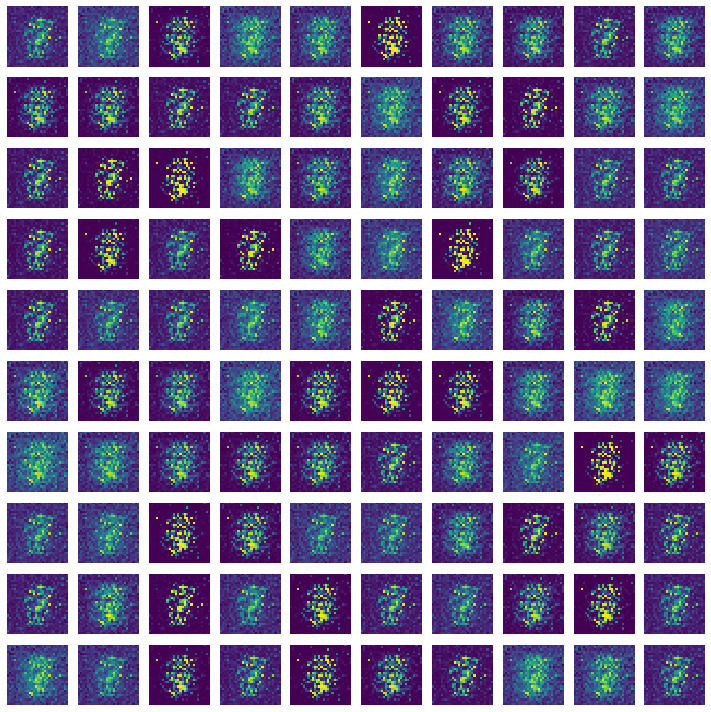

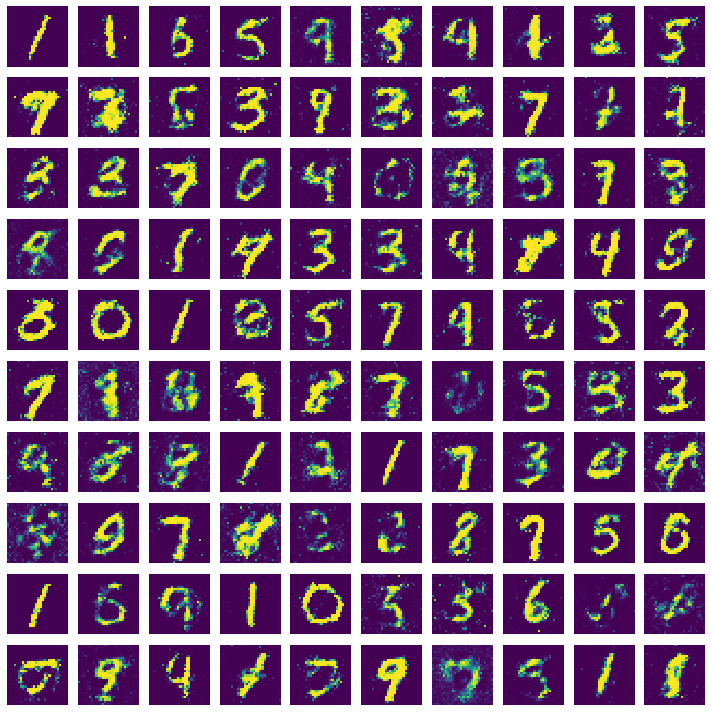

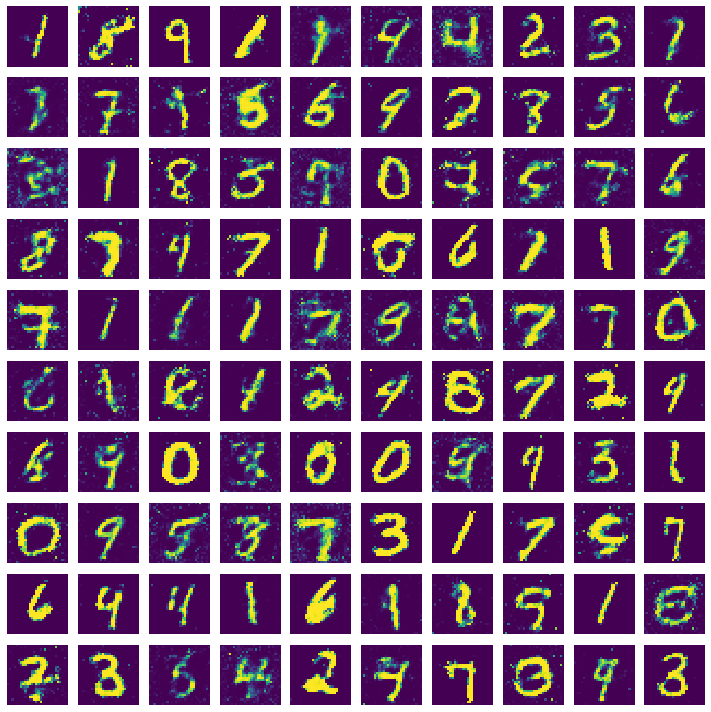

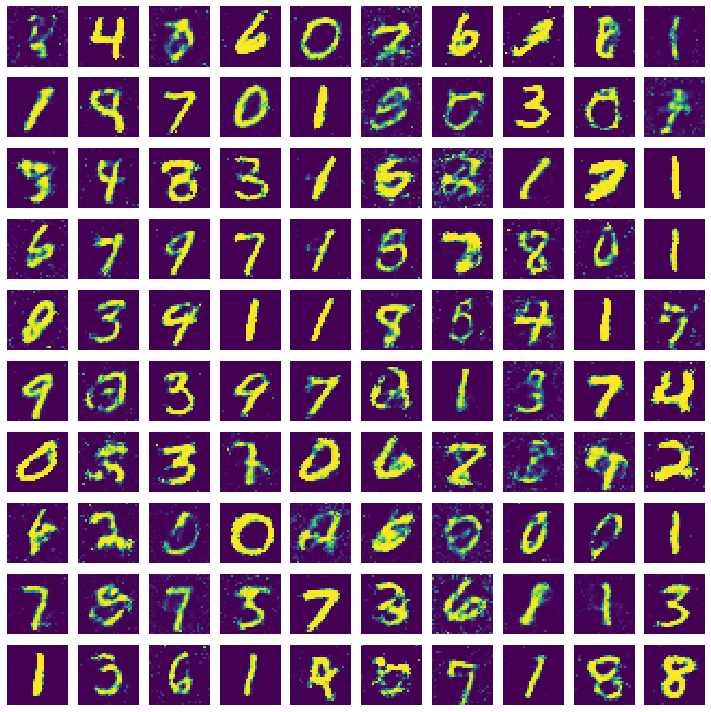

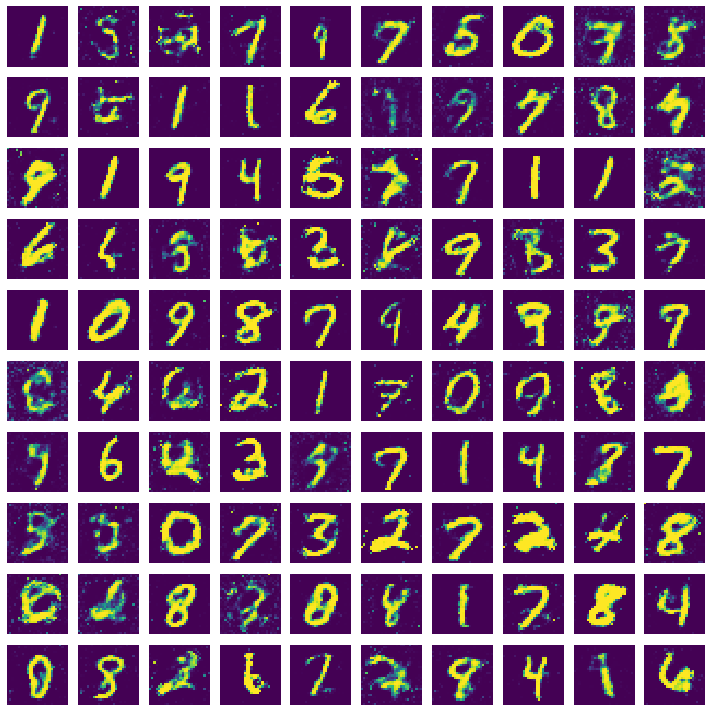

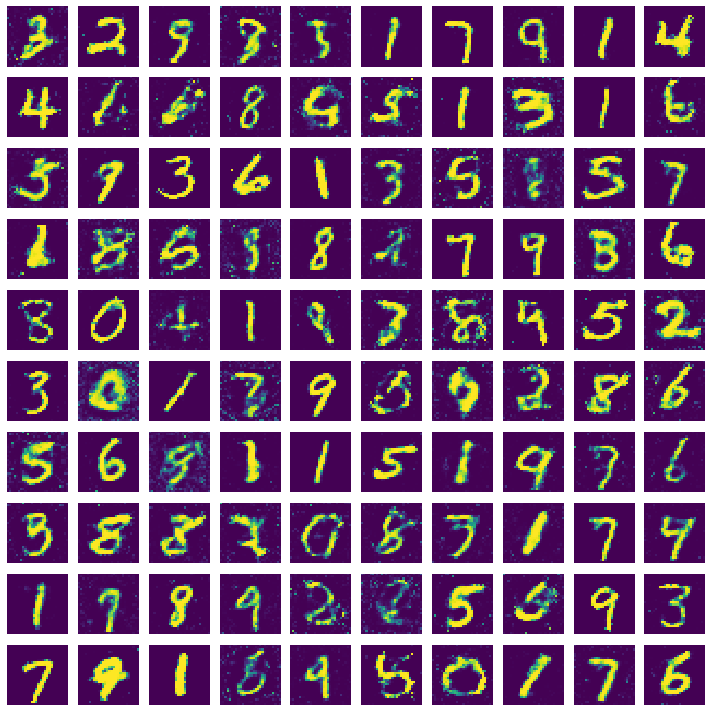

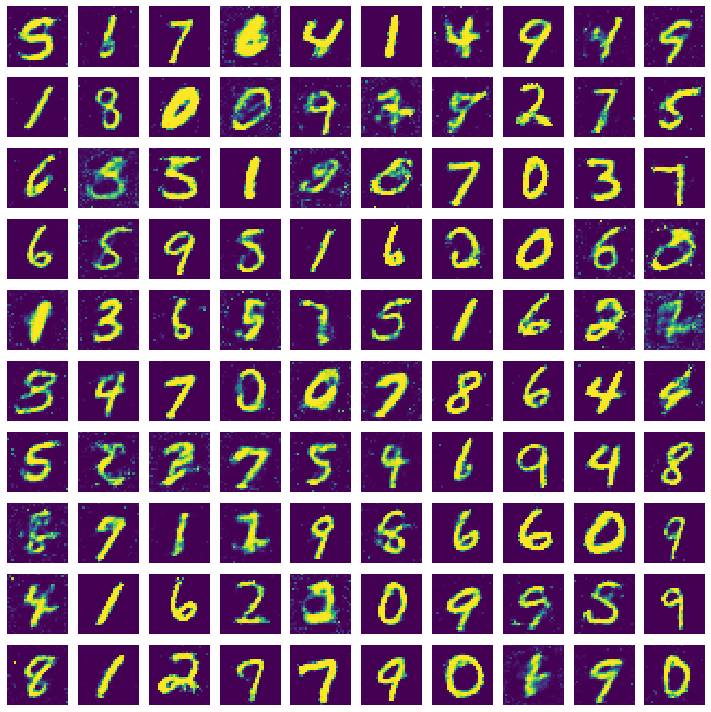

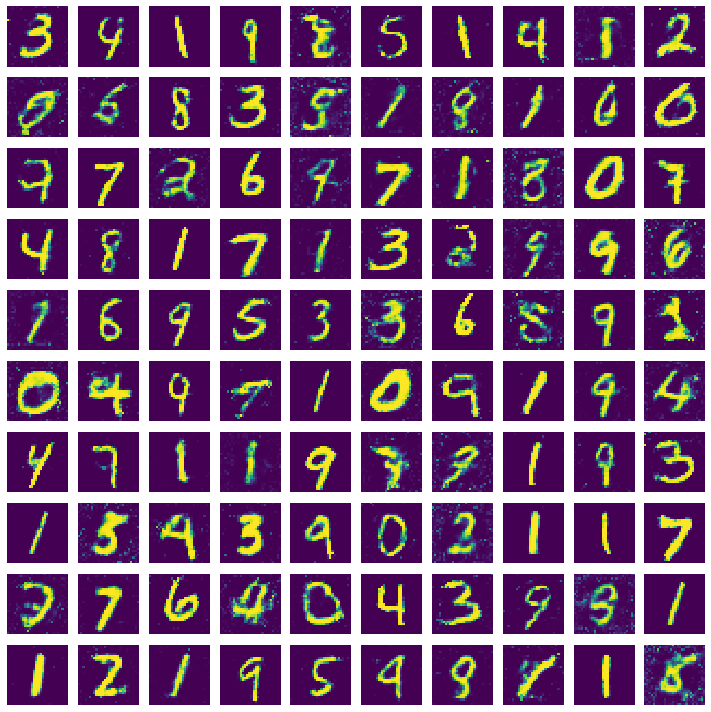

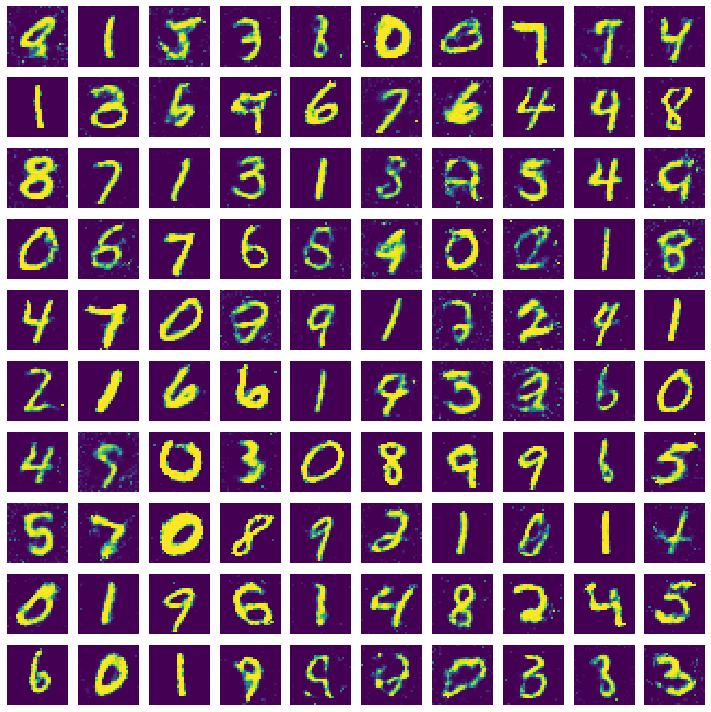

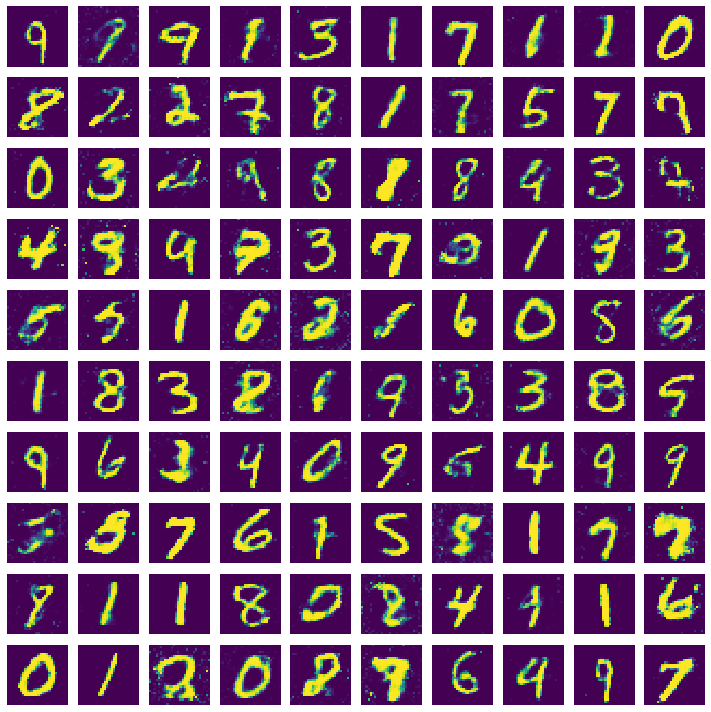

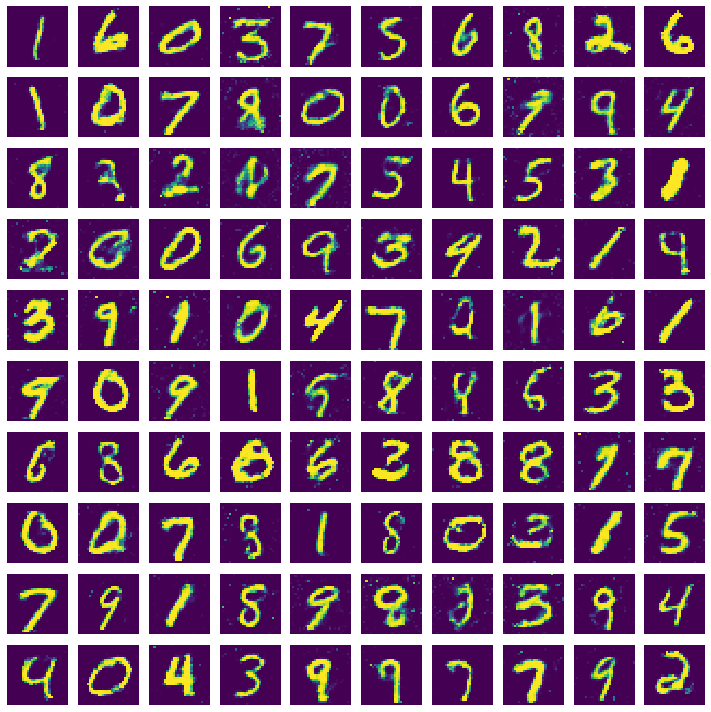

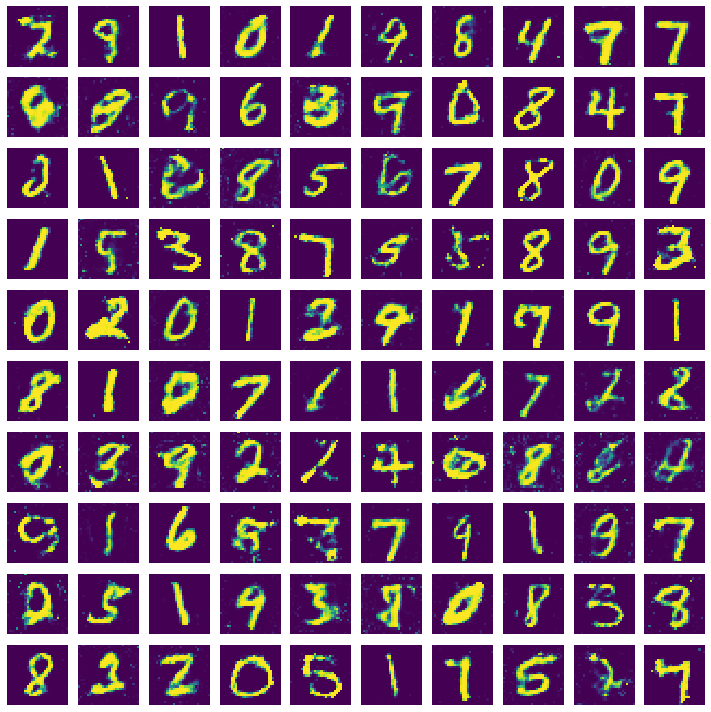

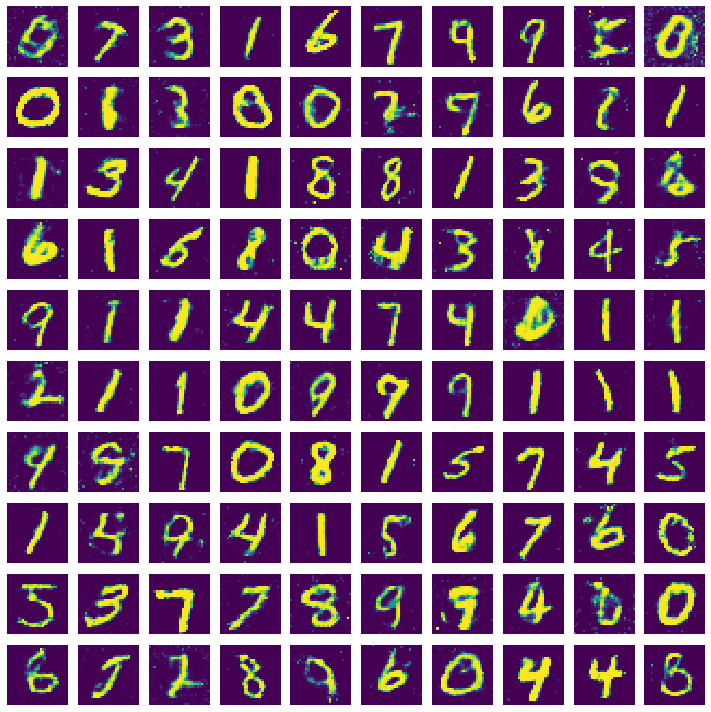

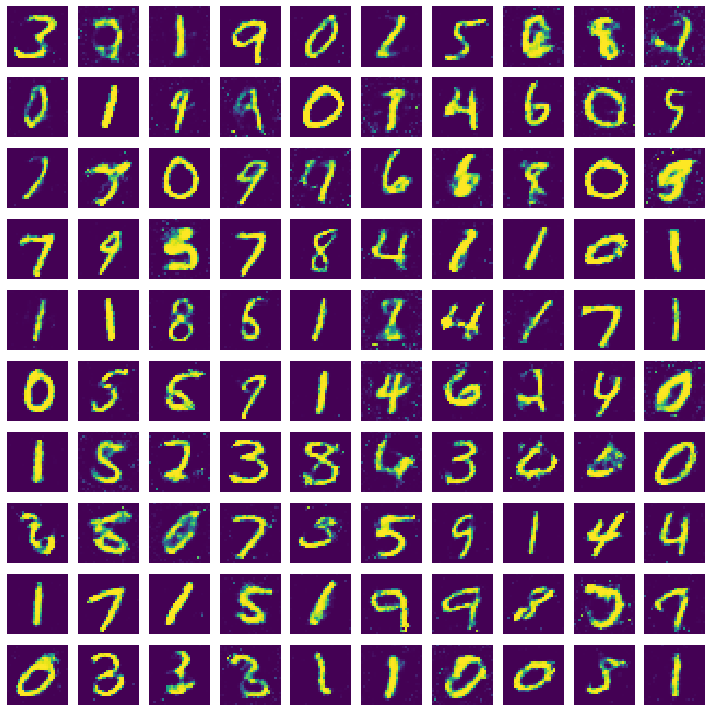

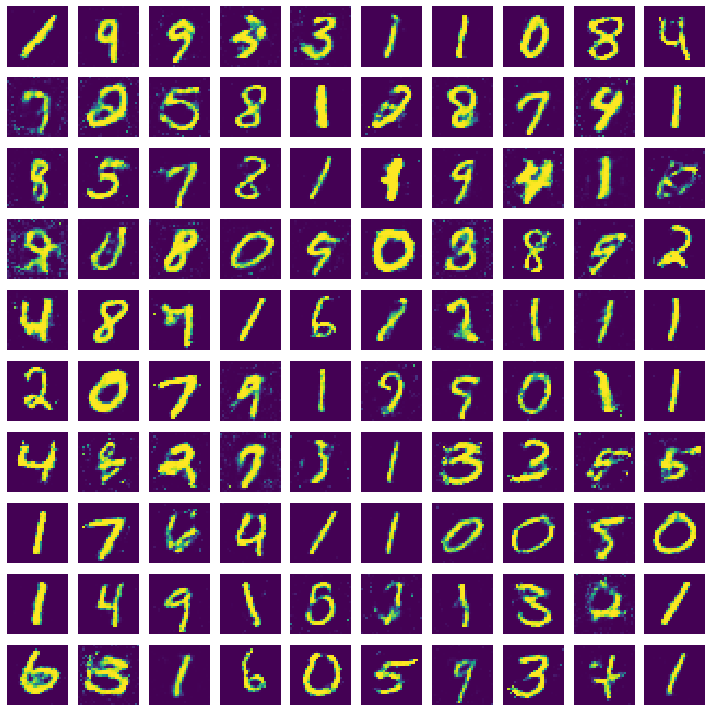

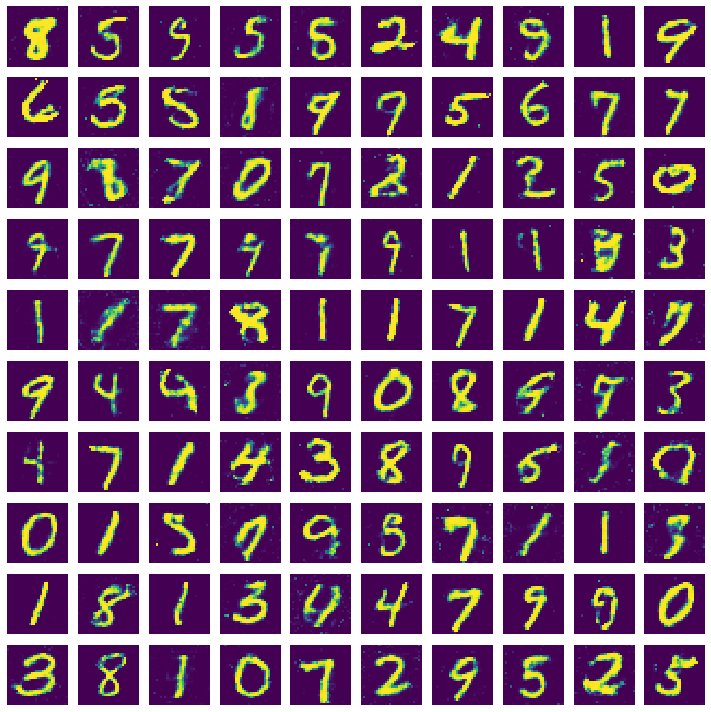

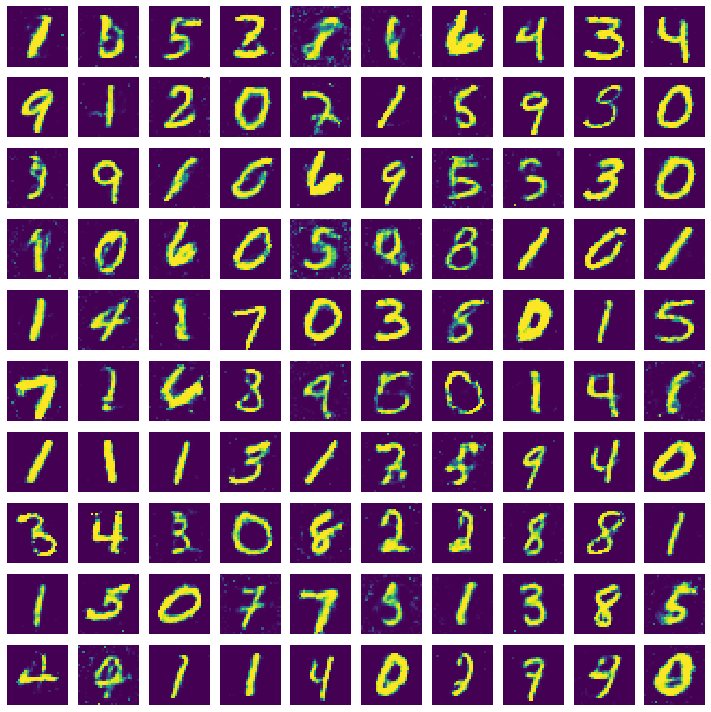

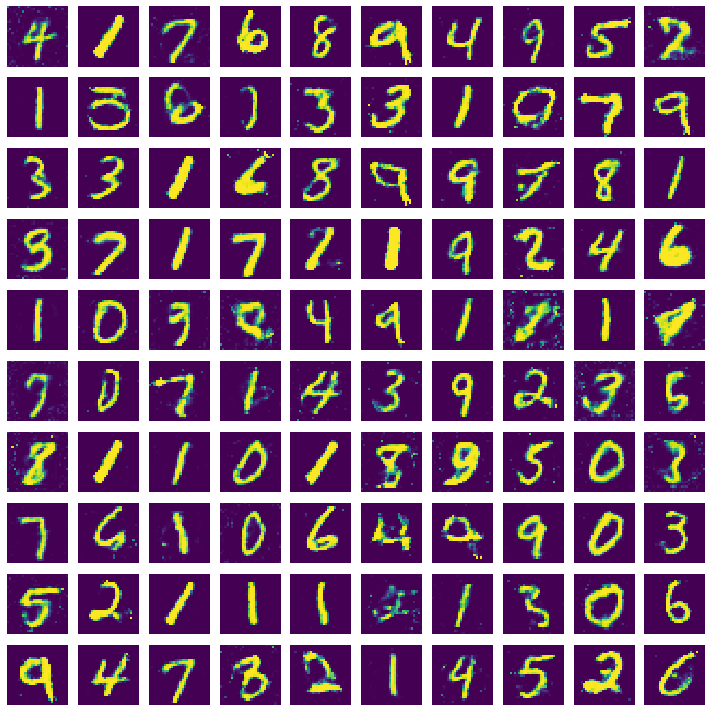

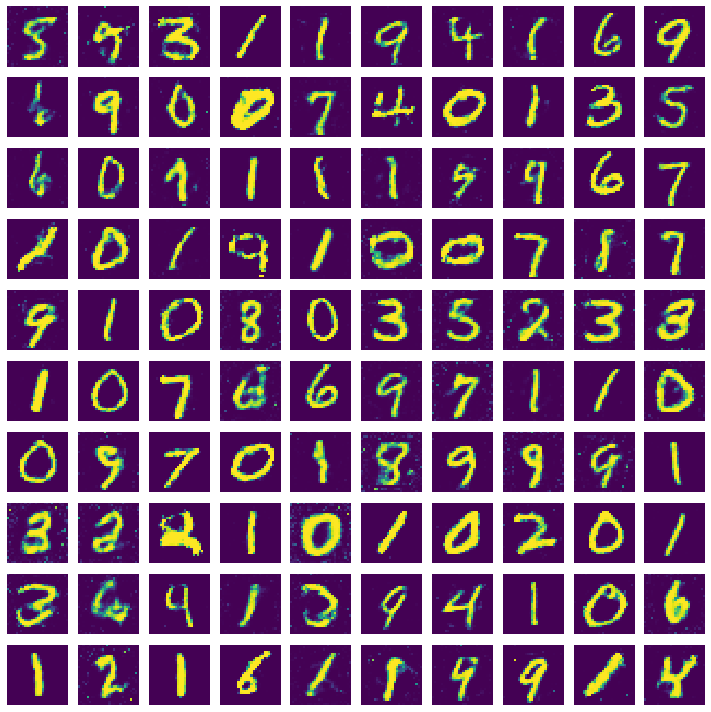

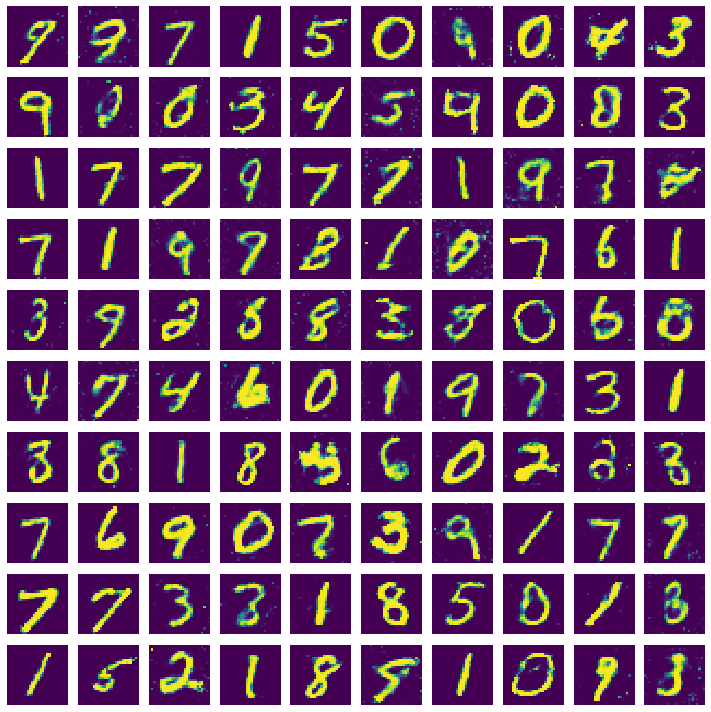

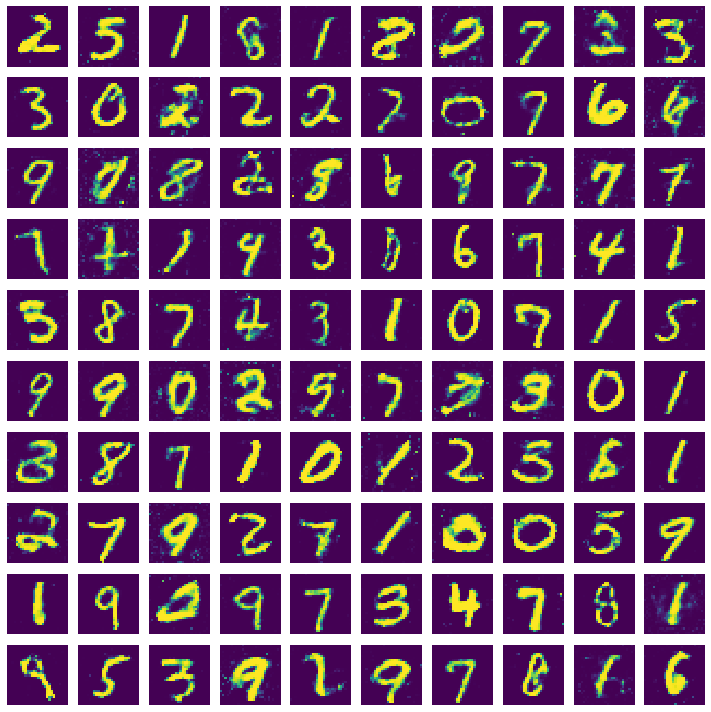

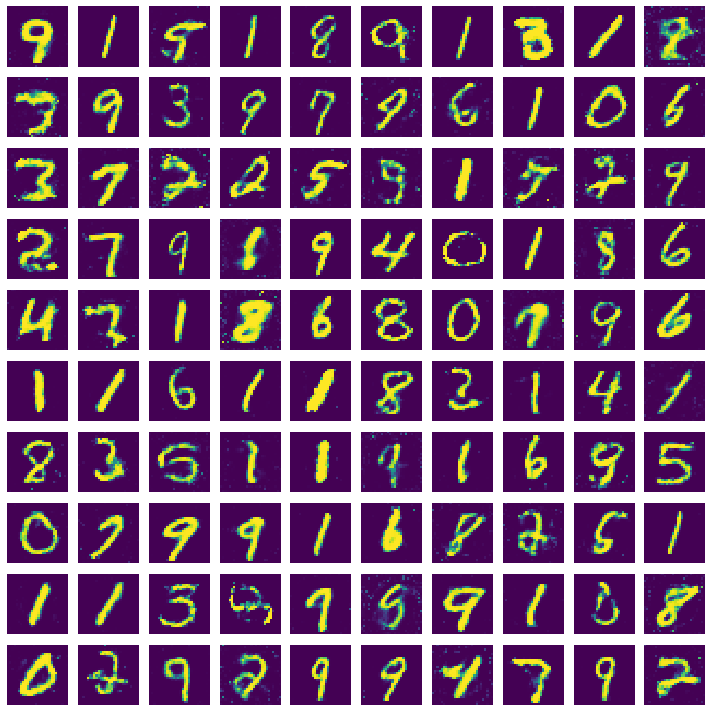

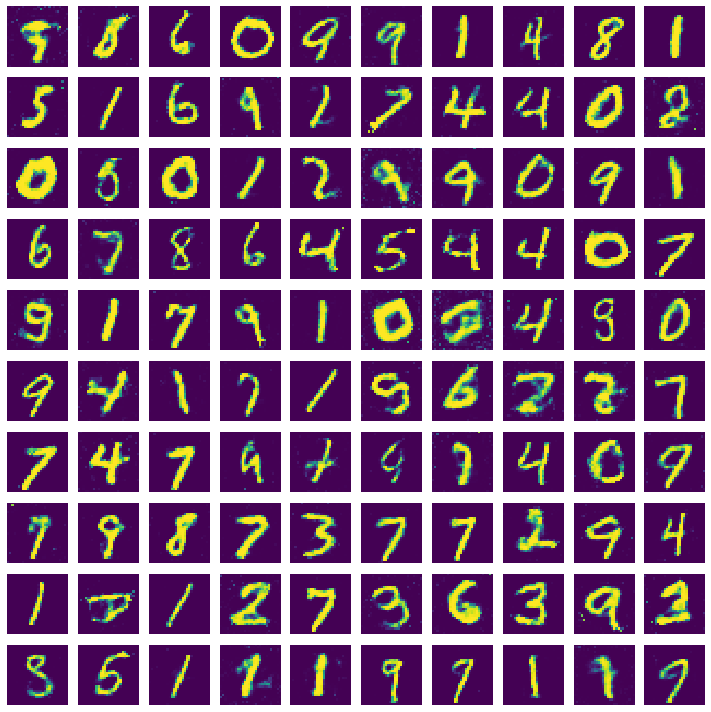

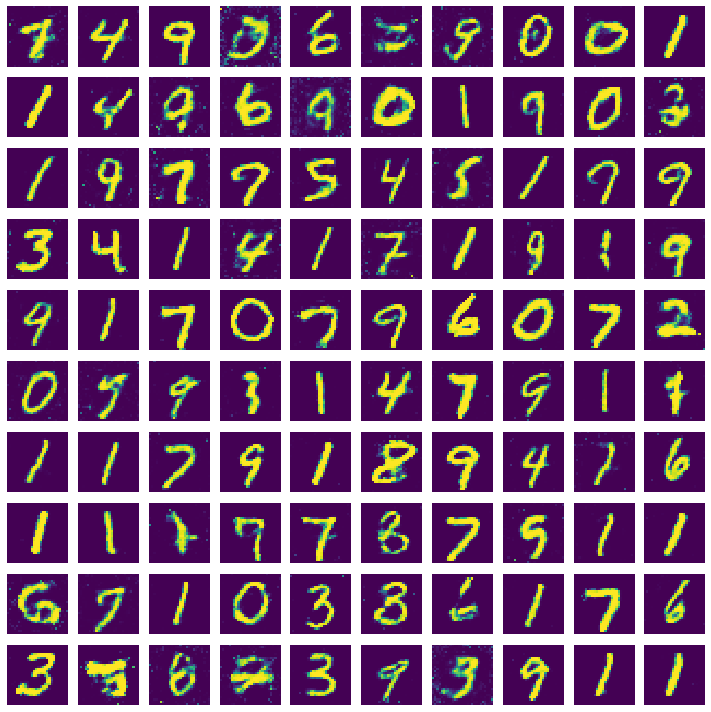

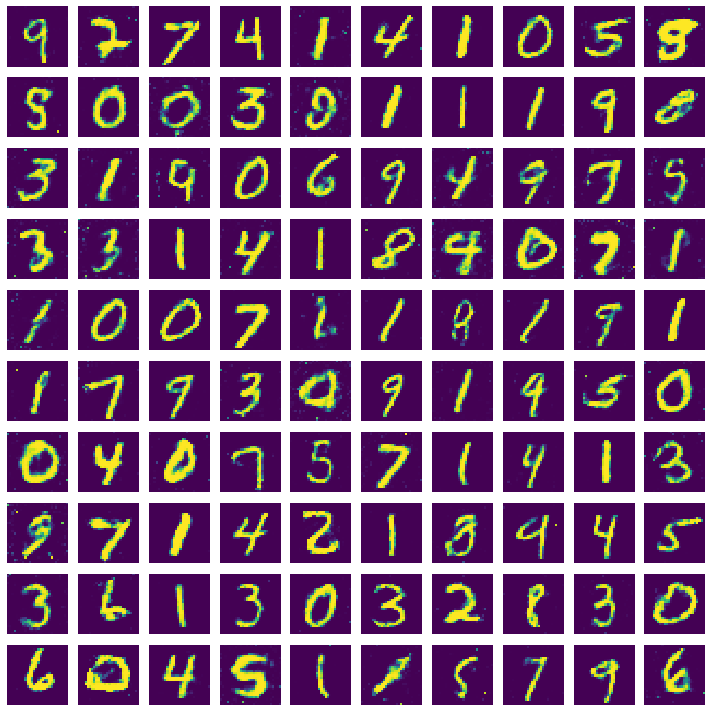

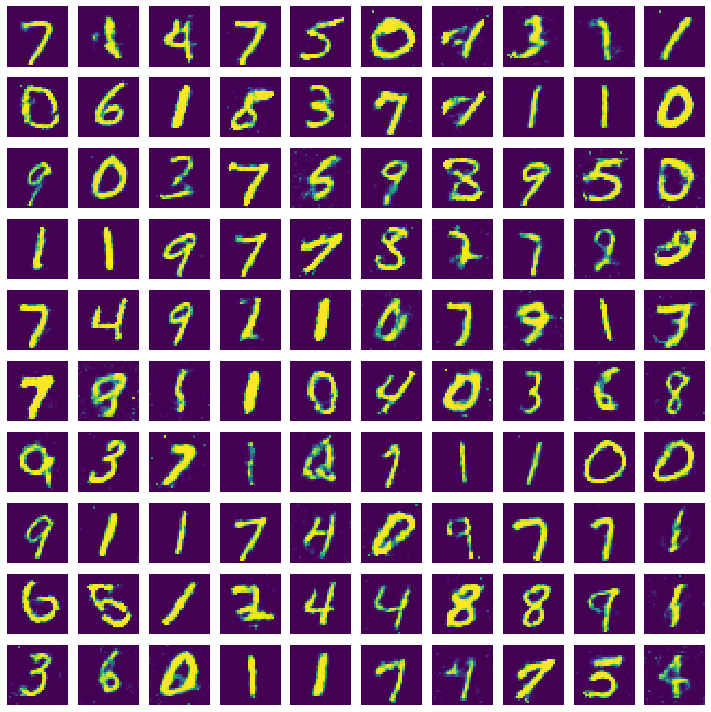

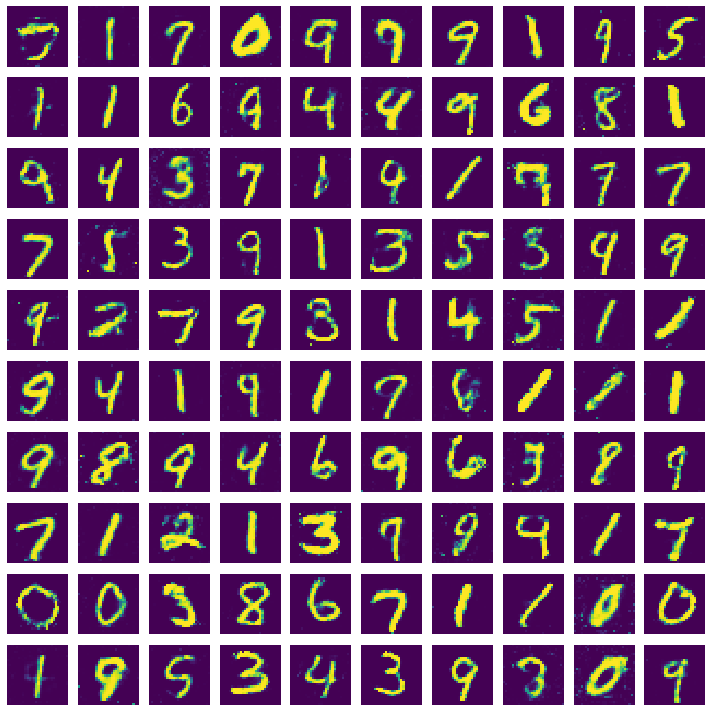

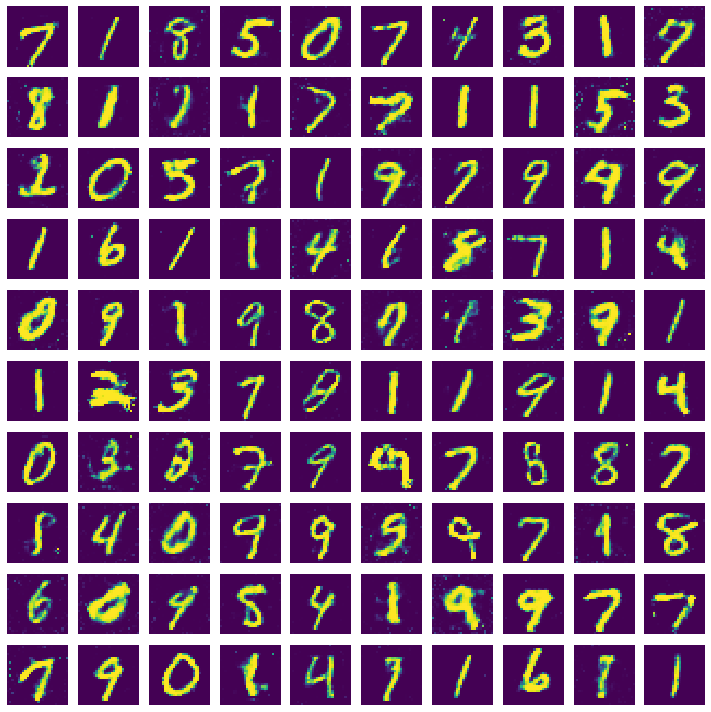

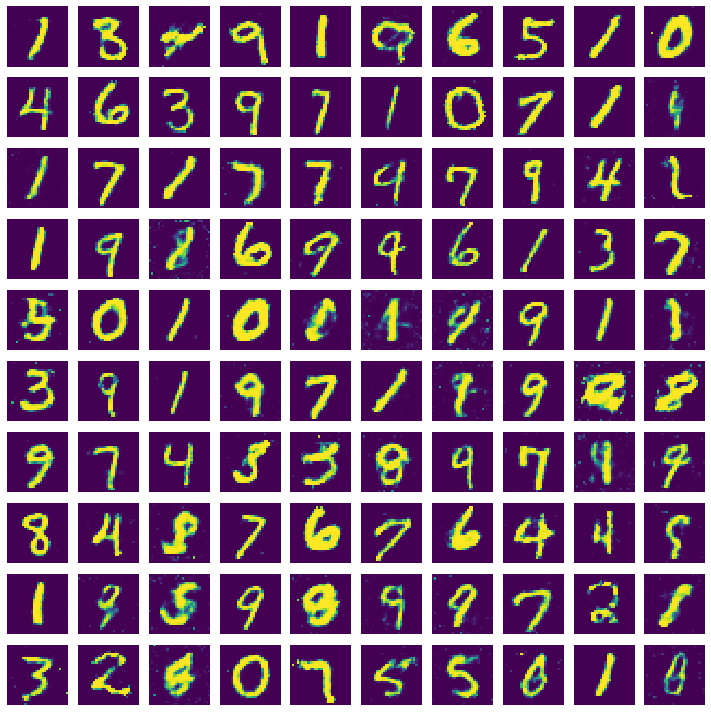

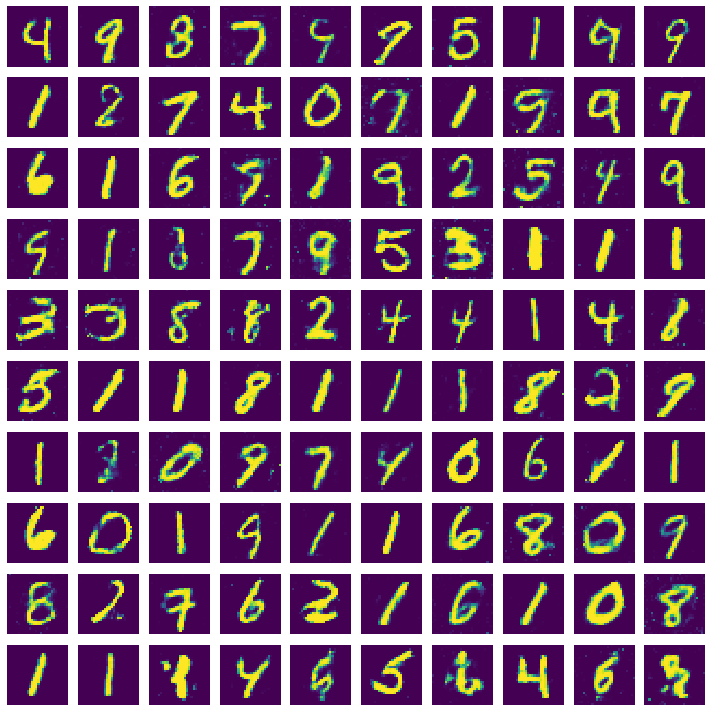

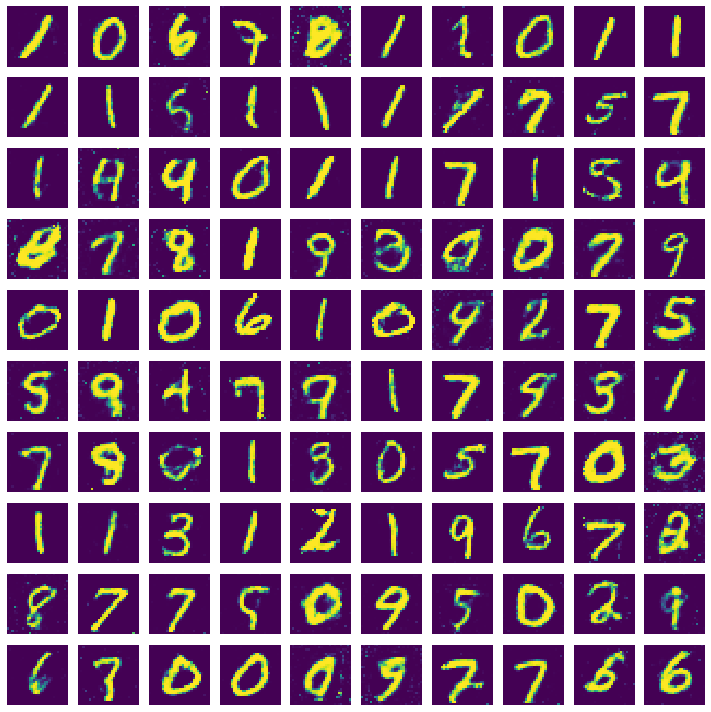

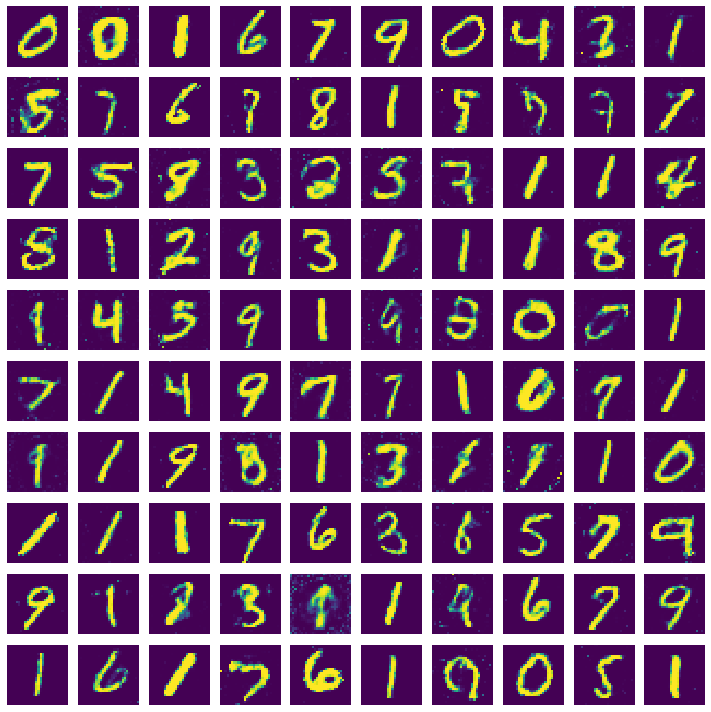

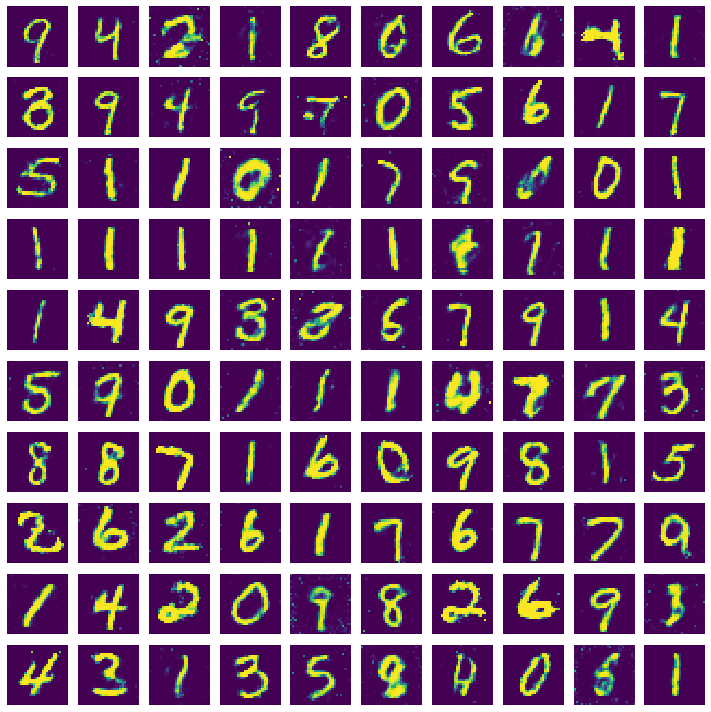

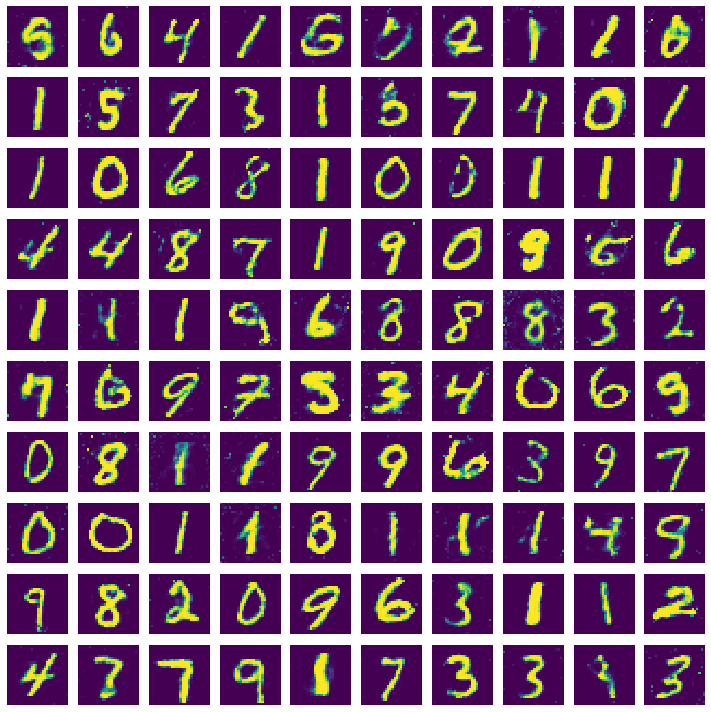

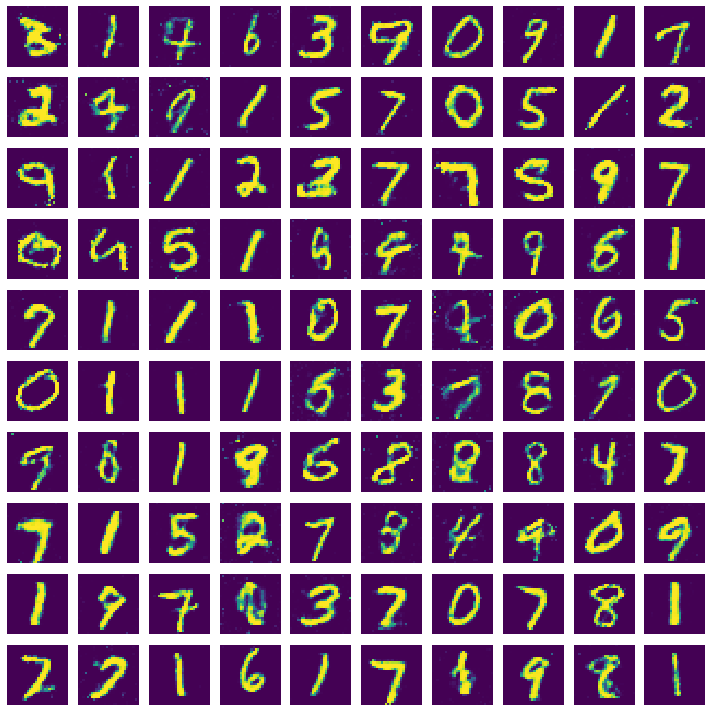

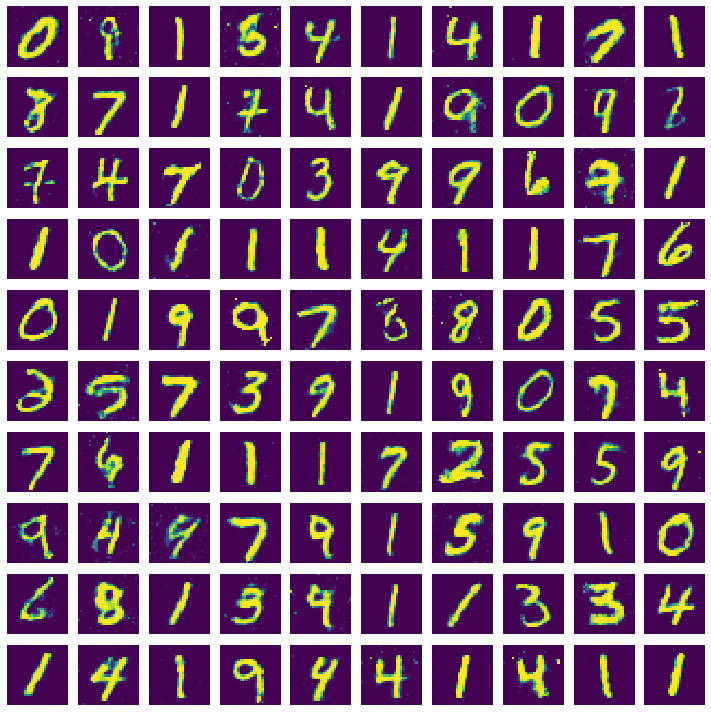

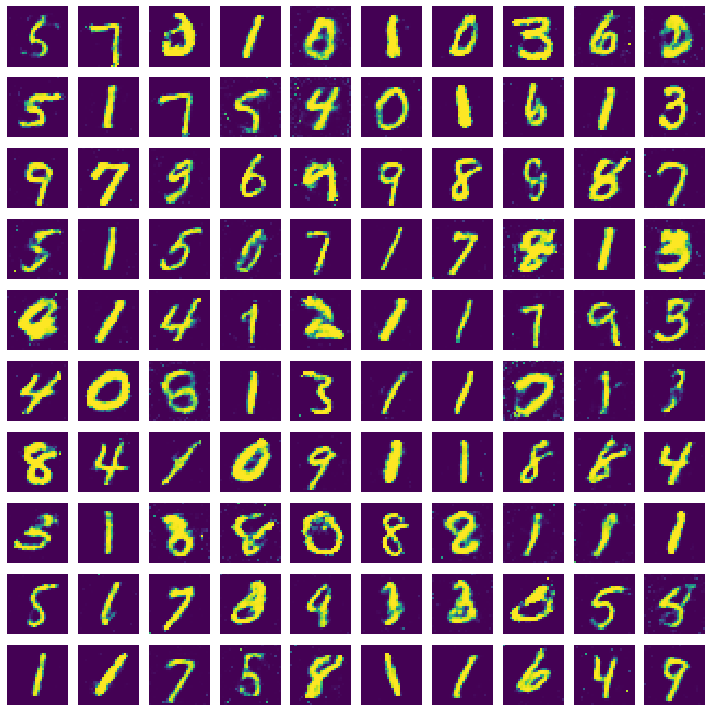

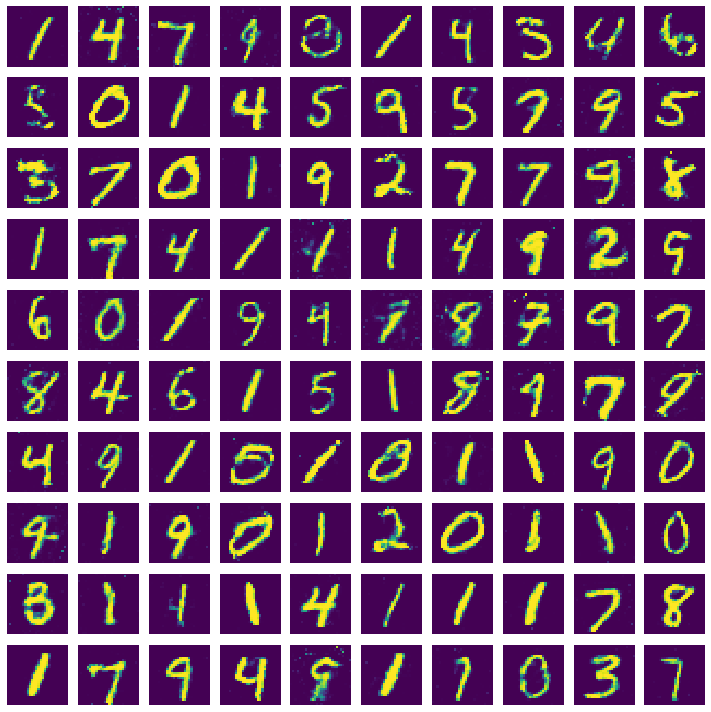

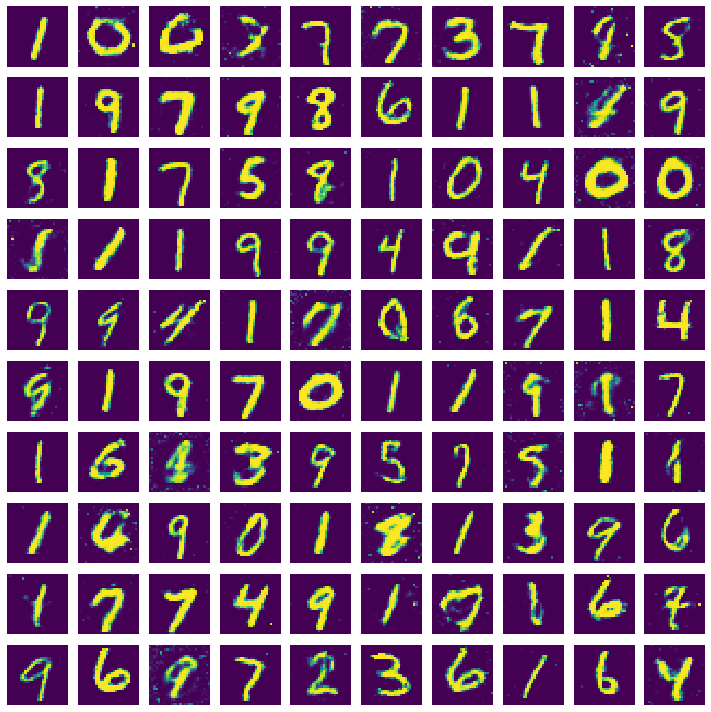

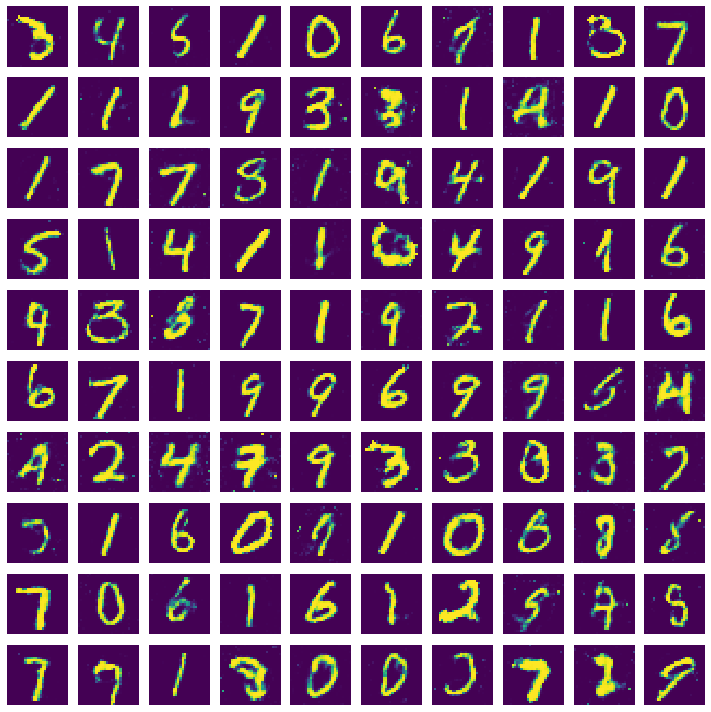

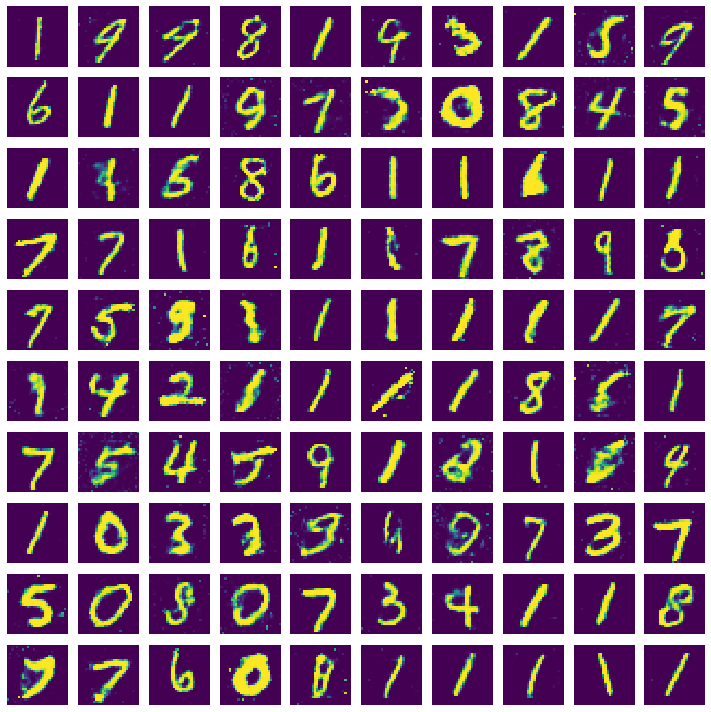

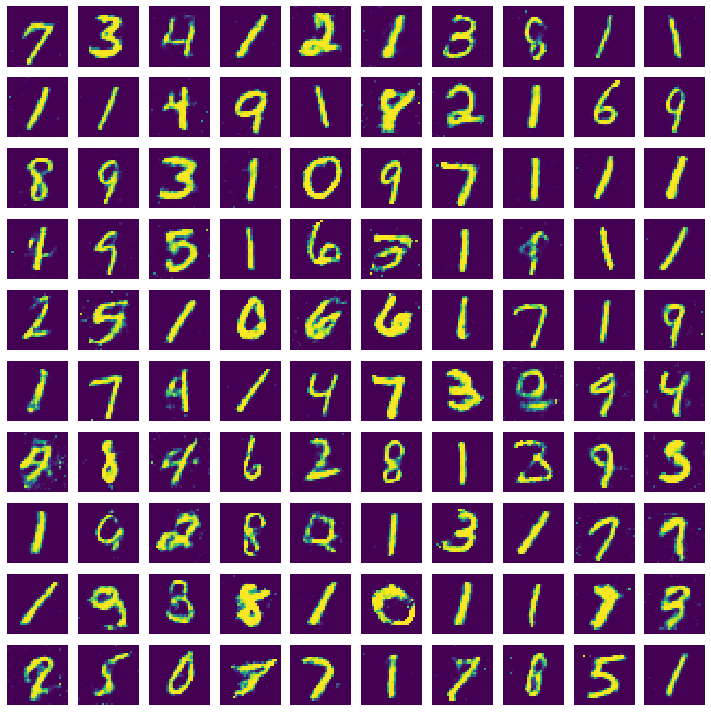

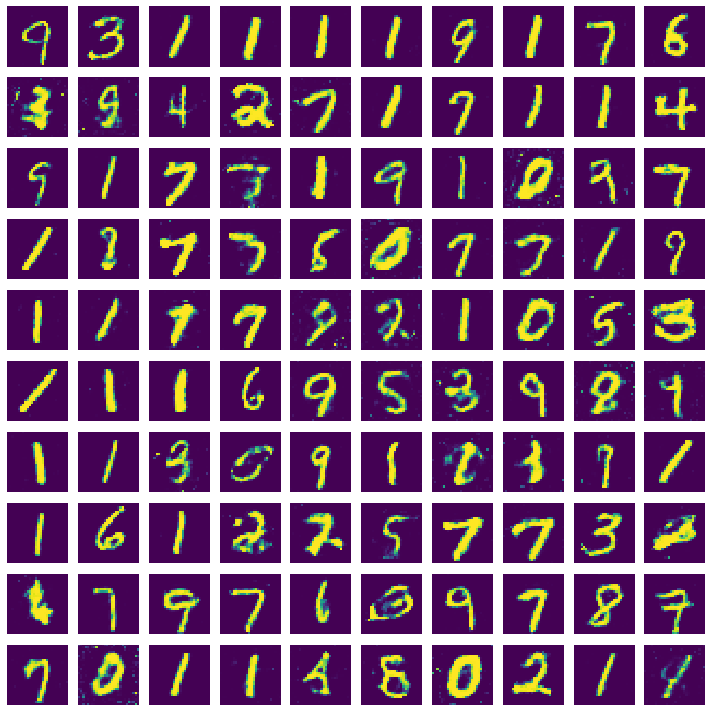

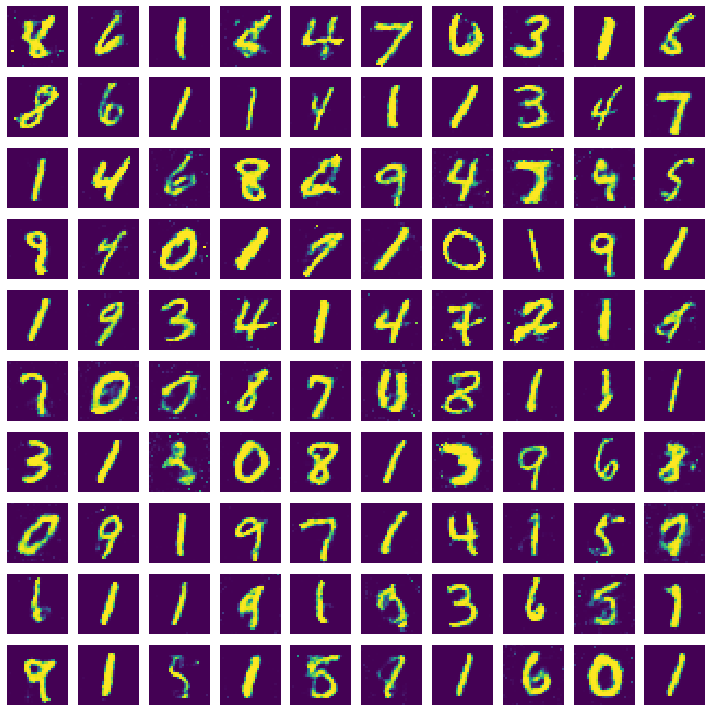

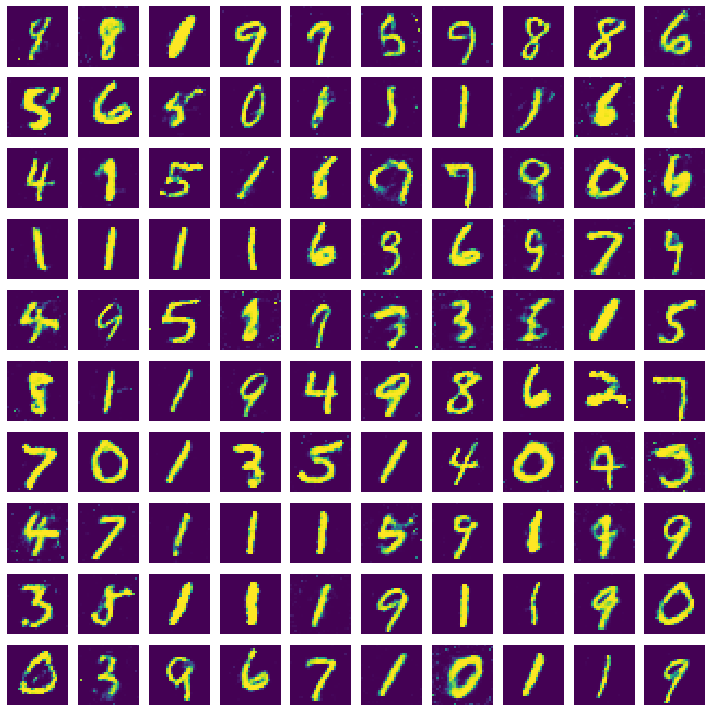

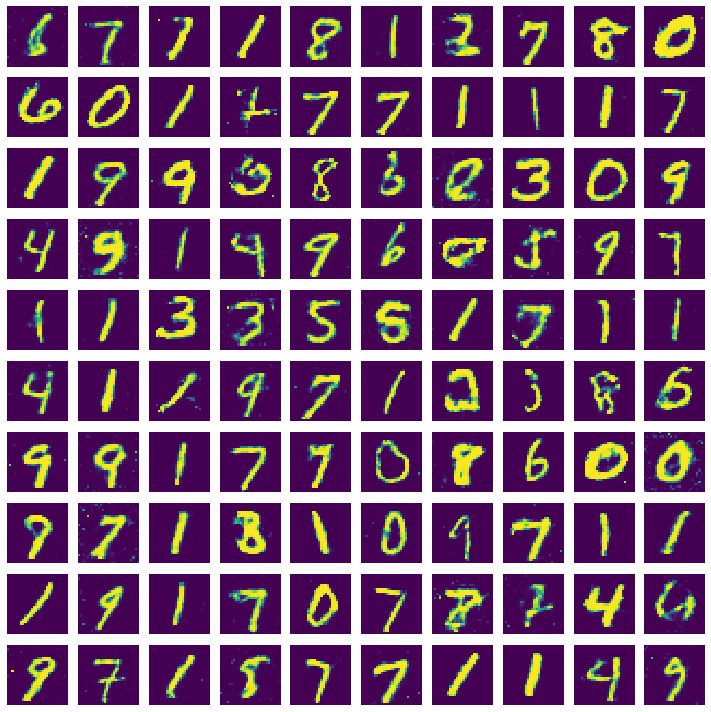

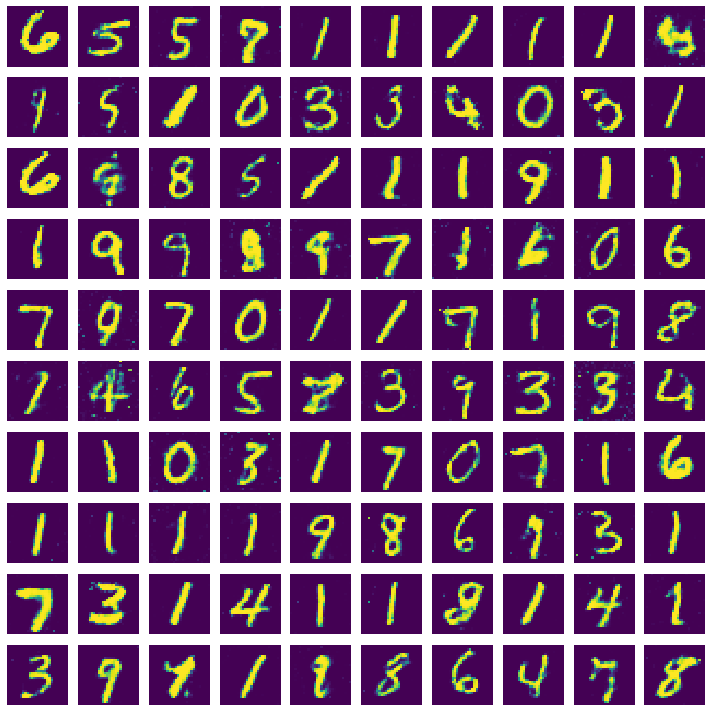

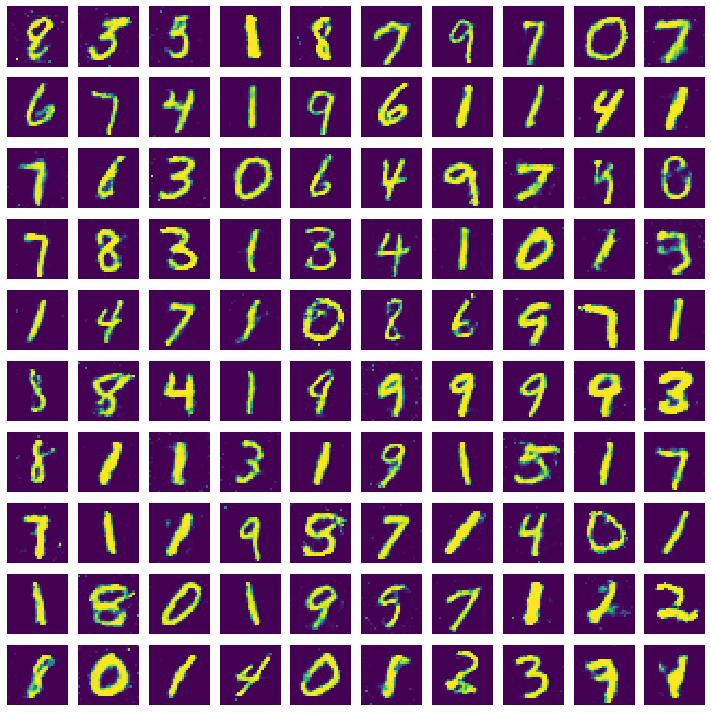

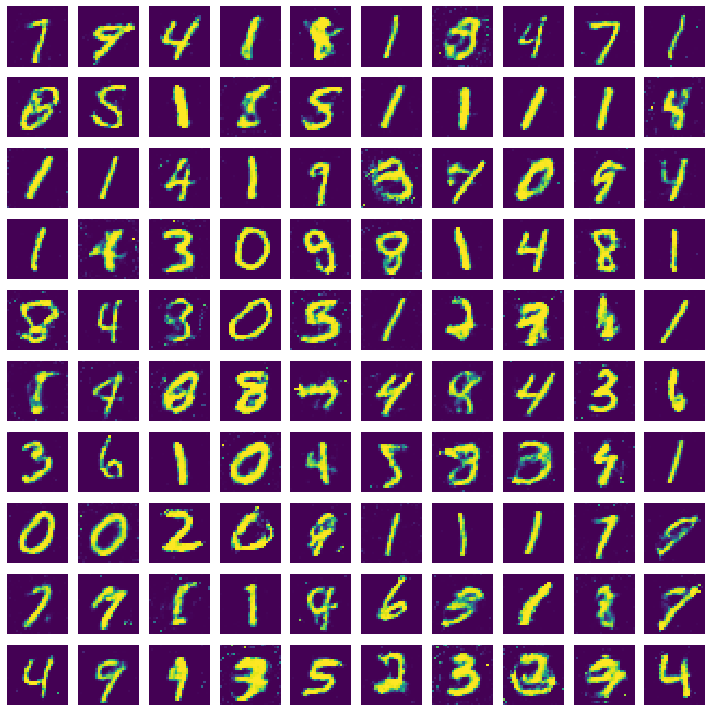

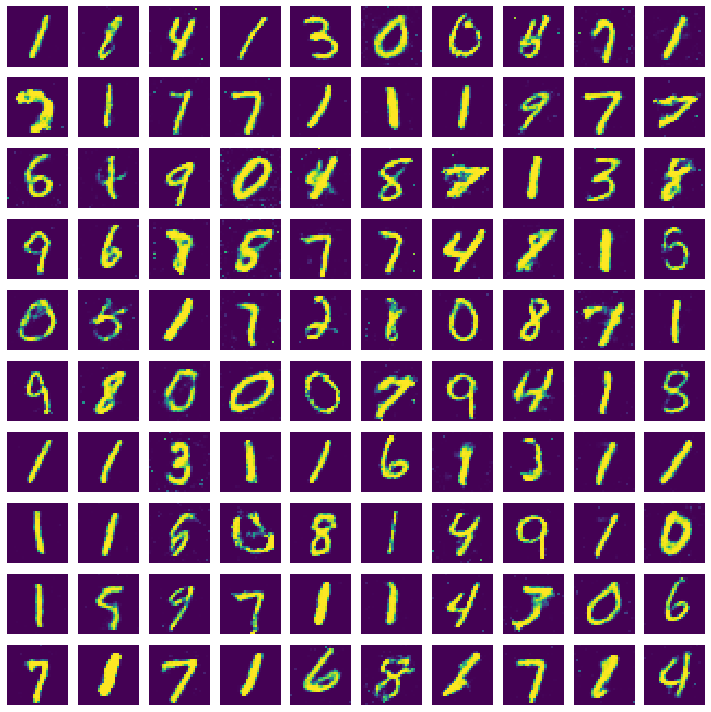

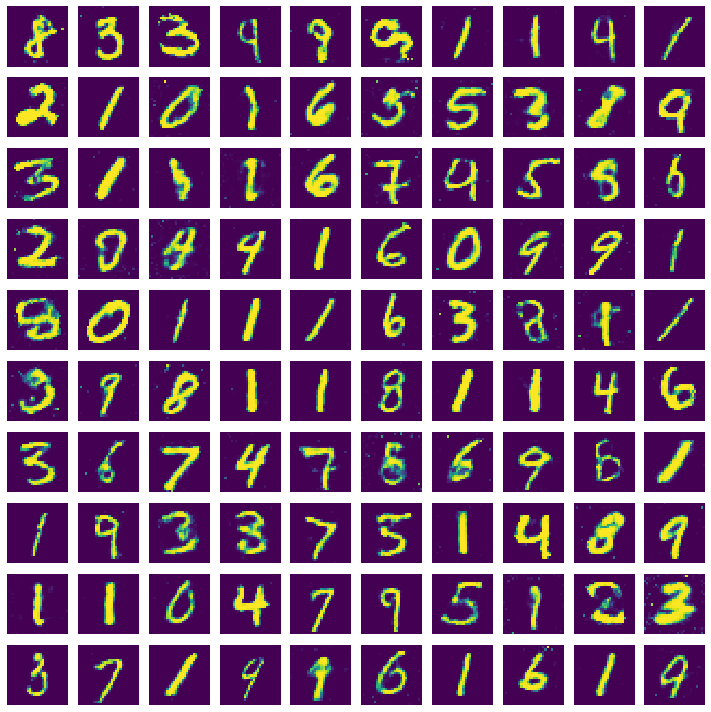

In [34]:
#epoch and bs size
training(1000,256)
